# Analisi su multi asset

Architettura di una Morning & Evening Star su paniere senza conferma.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ffn
import datetime
import seaborn as sns

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

def load_historical_complete_ffn(tickerlist,startdate,enddate):
    inner_tickerlist =  list(tickerlist.split(","))
    input_string = ""
    for ticker in inner_tickerlist:
        if ticker != "^VIX":
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close," +\
                                          ticker + ":Volume,"
        else:
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close,"
    input_string = input_string[:-1]
    print(input_string)
    #'aapl:Open,aapl:High,aapl:Low,aapl:Close'
    dataset = ffn.get(input_string, start = startdate, end = enddate).apply(lambda x: round(x,2))
    dataset.to_csv("universe_data.csv")
    return dataset

def load_historical_from_csv(filename):
    dataset = pd.read_csv(filename, parse_dates=["Date"])
    dataset.index = dataset.Date
    dataset.drop('Date', axis = 1, inplace = True)
    return dataset

def add_indicators(dataframe):
    service = dataframe.copy()
    service.columns = ["open","high","low","close","volume"]
    service["range_perc"] = (service.high - service.low) / service.low * 100
    service["body_perc"] = abs(service.close - service.open) / service.open * 100
    service["open_pos"] = (service.open - service.low) / (service.high - service.low) * 100
    service["close_pos"] = (service.close - service.low) / (service.high - service.low) * 100
    service["SMA20"] = service.close.rolling(20).mean()
    service["STD20"] = service.close.rolling(20).std()
    service["BBU"] = service.SMA20 + 2 * service.STD20
    service["BBL"] = service.SMA20 - 2 * service.STD20
    service.dropna(inplace = True)
    #print(service.head(10))
    return service

def pattern_stats(dataframe,pattern,direction,delay,ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i + 1)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.open, np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.open, np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def plot_patterns(dataframe,results):
    """
    Function that plots every single pattern occurrence
    """
    for date in results:
        single_case = dataframe[(dataframe.index >= (date)) & \
                                (dataframe.index <= (date + pd.Timedelta(days = 20)))]    
        graph_title = ticker + " from " + str(single_case.index[0]) + " - Powered by Gandalf Project R&D"

        #up_colors = np.where(single_case.index == date, "yellow", "green")
        #down_colors = np.where(single_case.index == date, "yellow", "red")

        single_case.iplot(kind = 'candle',theme = 'white',
                          up_color = "green", down_color = "red",
                          title = graph_title, xTitle = "Time", yTitle = "Prices")
    return

def create_asset_dataset(matrix):
    """
    Function that slices the original dataframe
    for each single asset
    """
    service = pd.DataFrame(index = matrix.index)
    for column in matrix.columns:
        #print(column)
        if ticker.lower() in column:
            service[column] = matrix[column]
    service = add_indicators(service)
    #print(service)
    return service

def positive_effect(basket_results):
    export = []
    for i in range(1, len(basket_results) + 1):
        positive = []
        for column in basket_results.columns:
            if basket_results[column][i] > 0:
                positive.append(column)
        export.append(positive)
        print("Positive inertia after", i, "bars:", positive)
    return export

In [7]:
load_new_data = True
tickerlist = "MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MSFT,NKE" #,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA,DIS"
startdate = "2007-01-01"
enddate = "2020-11-10"
days_after = 10
show_patterns = False

In [8]:
if load_new_data == True:
    matrix = load_historical_complete_ffn(tickerlist,startdate,enddate)
else:
    matrix = load_historical_from_csv("universe_data.csv")
    #print(matrix)

matrix.to_csv("universe_data.csv")
matrix.head(10)

MMM:Open,MMM:High,MMM:Low,MMM:Close,MMM:Volume,AXP:Open,AXP:High,AXP:Low,AXP:Close,AXP:Volume,AAPL:Open,AAPL:High,AAPL:Low,AAPL:Close,AAPL:Volume,BA:Open,BA:High,BA:Low,BA:Close,BA:Volume,CAT:Open,CAT:High,CAT:Low,CAT:Close,CAT:Volume,CVX:Open,CVX:High,CVX:Low,CVX:Close,CVX:Volume,CSCO:Open,CSCO:High,CSCO:Low,CSCO:Close,CSCO:Volume,KO:Open,KO:High,KO:Low,KO:Close,KO:Volume,XOM:Open,XOM:High,XOM:Low,XOM:Close,XOM:Volume,GS:Open,GS:High,GS:Low,GS:Close,GS:Volume,HD:Open,HD:High,HD:Low,HD:Close,HD:Volume,IBM:Open,IBM:High,IBM:Low,IBM:Close,IBM:Volume,INTC:Open,INTC:High,INTC:Low,INTC:Close,INTC:Volume,JNJ:Open,JNJ:High,JNJ:Low,JNJ:Close,JNJ:Volume,JPM:Open,JPM:High,JPM:Low,JPM:Close,JPM:Volume,MCD:Open,MCD:High,MCD:Low,MCD:Close,MCD:Volume,MSFT:Open,MSFT:High,MSFT:Low,MSFT:Close,MSFT:Volume,NKE:Open,NKE:High,NKE:Low,NKE:Close,NKE:Volume


,mmmopen,mmmhigh,mmmlow,mmmclose,mmmvolume,axpopen,axphigh,axplow,axpclose,axpvolume,...,msftopen,msfthigh,msftlow,msftclose,msftvolume,nkeopen,nkehigh,nkelow,nkeclose,nkevolume
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,77.53,78.85,77.38,78.26,3781500.0,61.18,61.90,60.05,60.36,6142500.0,...,29.91,30.25,29.40,29.86,76935100.0,12.25,12.46,12.10,12.21,17299200.0
2007-01-04,78.40,78.41,77.45,77.95,2968400.0,60.23,60.57,59.79,59.92,5671200.0,...,29.70,29.97,29.44,29.81,45774500.0,12.21,12.37,12.11,12.33,15085600.0
2007-01-05,77.89,77.90,77.01,77.42,2765200.0,59.65,59.87,58.90,59.13,6768100.0,...,29.63,29.75,29.45,29.64,44607200.0,12.26,12.43,12.21,12.35,14996800.0
2007-01-08,77.42,78.04,76.97,77.59,2434500.0,59.03,59.76,58.35,59.69,5000200.0,...,29.65,30.10,29.53,29.93,50220200.0,12.31,12.37,12.20,12.32,10109600.0
2007-01-09,78.00,78.23,77.44,77.68,1896800.0,59.90,59.95,59.00,59.31,4968000.0,...,30.00,30.18,29.73,29.96,44636600.0,12.32,12.49,12.30,12.47,15167200.0
2007-01-10,77.31,77.96,77.04,77.85,1787500.0,59.24,59.37,58.71,59.27,4366800.0,...,29.80,29.89,29.43,29.66,55017400.0,12.40,12.48,12.36,12.47,13012800.0
2007-01-11,78.05,79.03,77.88,78.65,2372500.0,59.25,59.57,59.06,59.45,4204900.0,...,29.76,30.75,29.65,30.70,99464300.0,12.49,12.54,12.43,12.50,14316000.0
2007-01-12,78.41,79.50,78.22,79.36,2582200.0,59.35,59.41,58.76,59.01,5002900.0,...,30.65,31.39,30.64,31.21,103972500.0,12.44,12.50,12.41,12.47,9296800.0
2007-01-16,79.48,79.62,78.92,79.56,2526600.0,58.85,59.18,58.68,59.13,5354200.0,...,31.26,31.45,31.03,31.16,62379600.0,12.44,12.50,12.40,12.50,9264800.0


# <span style="color:green">Esempio pattern "Morning Star"</span>

Pattern analysis on: MMM

Occurrences: 7 

DatetimeIndex(['2008-06-10', '2012-03-08', '2013-06-07', '2014-03-17',
               '2014-09-29', '2015-03-12', '2020-05-15'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 2.92 average of 0.42 with 2 winning trades and 5 loosing trades
After: 2 days: 1.92 average of 0.27 with 3 winning trades and 4 loosing trades
After: 3 days: 2.52 average of 0.36 with 4 winning trades and 3 loosing trades
After: 4 days: 4.45 average of 0.64 with 4 winning trades and 3 loosing trades
After: 5 days: 4.47 average of 0.64 with 3 winning trades and 4 loosing trades
After: 6 days: 9.69 average of 1.38 with 5 winning trades and 2 loosing trades
After: 7 days: 19.22 average of 2.75 with 5 winning trades and 2 loosing trades
After: 8 days: 12.17 average of 1.74 with 5 winning trades and 2 loosing trades
After: 9 days: 1.43 average of 0.2 with 3 winning trades and 4 loosing trades
After: 10 days: 0.93 average of 0.13 with 3 winning 

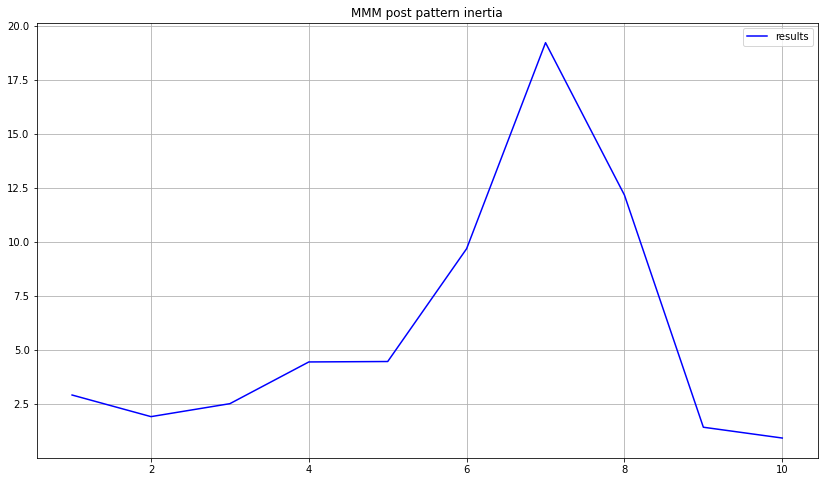


Pattern analysis on: AXP

Occurrences: 14 

DatetimeIndex(['2007-07-12', '2008-06-24', '2008-07-16', '2012-05-21',
               '2012-11-16', '2013-10-10', '2014-04-09', '2015-10-23',
               '2016-06-16', '2016-06-29', '2017-04-17', '2017-08-14',
               '2019-06-04', '2019-10-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.77 average of 0.06 with 7 winning trades and 7 loosing trades
After: 2 days: -0.98 average of -0.07 with 8 winning trades and 6 loosing trades
After: 3 days: 5.49 average of 0.39 with 10 winning trades and 4 loosing trades
After: 4 days: 5.4 average of 0.39 with 8 winning trades and 6 loosing trades
After: 5 days: 18.2 average of 1.3 with 8 winning trades and 6 loosing trades
After: 6 days: 8.73 average of 0.62 with 7 winning trades and 7 loosing trades
After: 7 days: 10.75 average of 0.77 with 8 winning trades and 6 loosing trades
After: 8 days: 5.2 average of 0.37 with 7 winning trades and 7 loosing trades
A

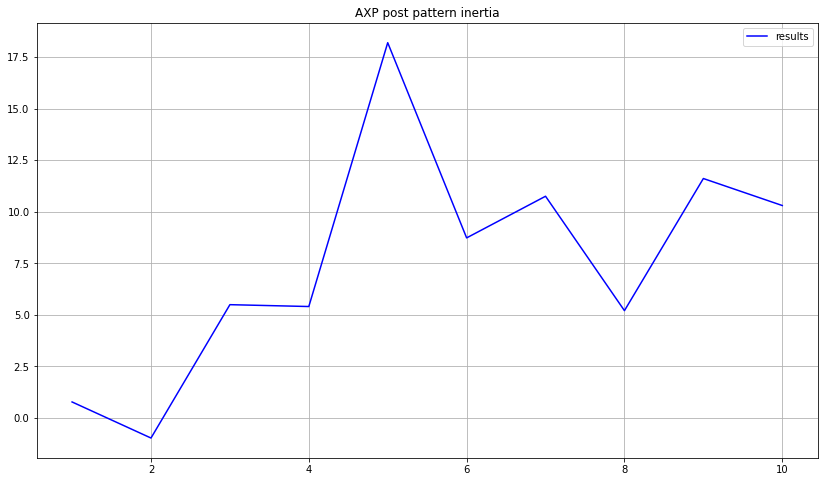


Pattern analysis on: AAPL

Occurrences: 13 

DatetimeIndex(['2008-06-16', '2008-07-22', '2009-12-09', '2010-11-18',
               '2011-06-21', '2011-11-22', '2012-05-21', '2012-11-19',
               '2013-09-12', '2016-06-21', '2018-02-12', '2018-12-26',
               '2019-08-07'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.04 average of -0.0 with 5 winning trades and 8 loosing trades
After: 2 days: 0.25 average of 0.02 with 7 winning trades and 6 loosing trades
After: 3 days: 1.97 average of 0.15 with 7 winning trades and 6 loosing trades
After: 4 days: 4.25 average of 0.33 with 6 winning trades and 7 loosing trades
After: 5 days: -0.02 average of -0.0 with 8 winning trades and 5 loosing trades
After: 6 days: 1.46 average of 0.11 with 7 winning trades and 6 loosing trades
After: 7 days: 4.39 average of 0.34 with 8 winning trades and 5 loosing trades
After: 8 days: 6.37 average of 0.49 with 7 winning trades and 6 loosing trades
After: 9 days

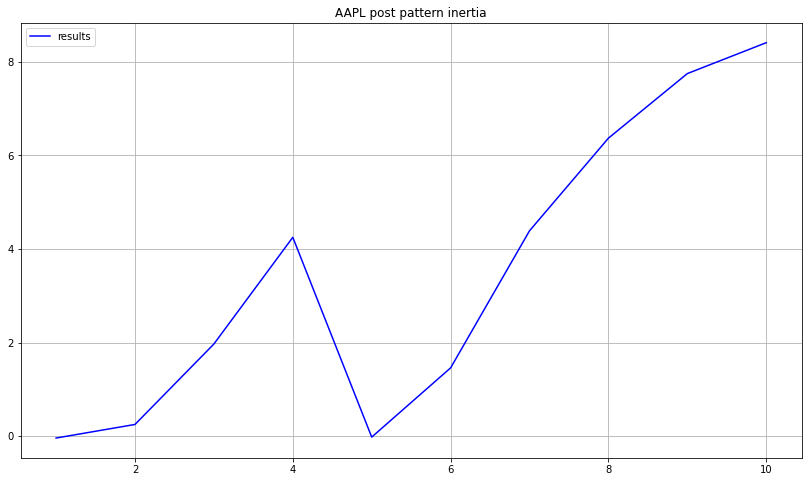


Pattern analysis on: BA

Occurrences: 8 

DatetimeIndex(['2008-01-10', '2011-03-03', '2012-03-07', '2012-04-12',
               '2014-03-17', '2014-10-03', '2017-05-19', '2019-05-15'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.07 average of 0.13 with 1 winning trades and 7 loosing trades
After: 2 days: -3.53 average of -0.44 with 1 winning trades and 7 loosing trades
After: 3 days: -1.78 average of -0.22 with 4 winning trades and 4 loosing trades
After: 4 days: 5.02 average of 0.63 with 5 winning trades and 3 loosing trades
After: 5 days: -2.69 average of -0.34 with 3 winning trades and 5 loosing trades
After: 6 days: -5.2 average of -0.65 with 4 winning trades and 4 loosing trades
After: 7 days: -1.37 average of -0.17 with 3 winning trades and 5 loosing trades
After: 8 days: -5.65 average of -0.71 with 4 winning trades and 4 loosing trades
After: 9 days: -4.81 average of -0.6 with 4 winning trades and 4 loosing trades
After: 10 days: -1.24 avera

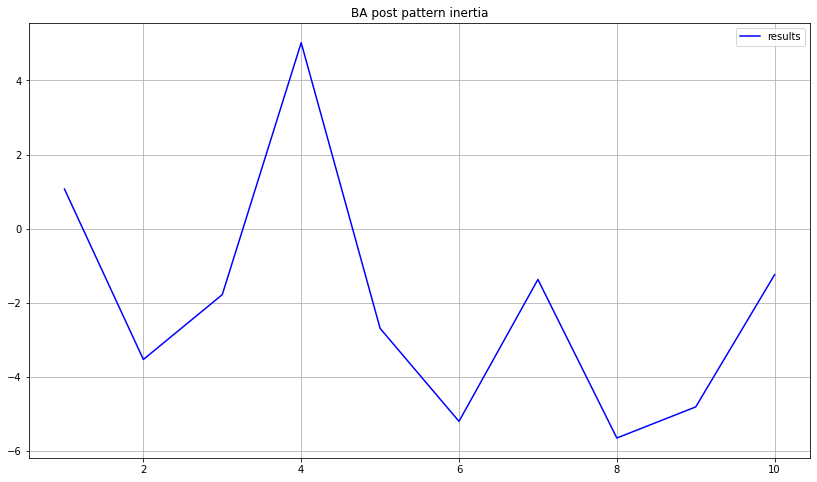


Pattern analysis on: CAT

Occurrences: 13 

DatetimeIndex(['2009-05-29', '2011-11-28', '2012-03-07', '2012-03-23',
               '2012-06-06', '2012-09-06', '2013-02-27', '2014-08-04',
               '2014-09-24', '2015-07-28', '2016-09-15', '2017-03-15',
               '2019-10-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.6 average of -0.2 with 6 winning trades and 7 loosing trades
After: 2 days: 1.83 average of 0.14 with 6 winning trades and 7 loosing trades
After: 3 days: -3.66 average of -0.28 with 7 winning trades and 6 loosing trades
After: 4 days: 7.35 average of 0.57 with 7 winning trades and 6 loosing trades
After: 5 days: 11.94 average of 0.92 with 7 winning trades and 6 loosing trades
After: 6 days: 14.79 average of 1.14 with 7 winning trades and 6 loosing trades
After: 7 days: 17.09 average of 1.31 with 8 winning trades and 5 loosing trades
After: 8 days: 16.23 average of 1.25 with 7 winning trades and 6 loosing trades
After: 9 d

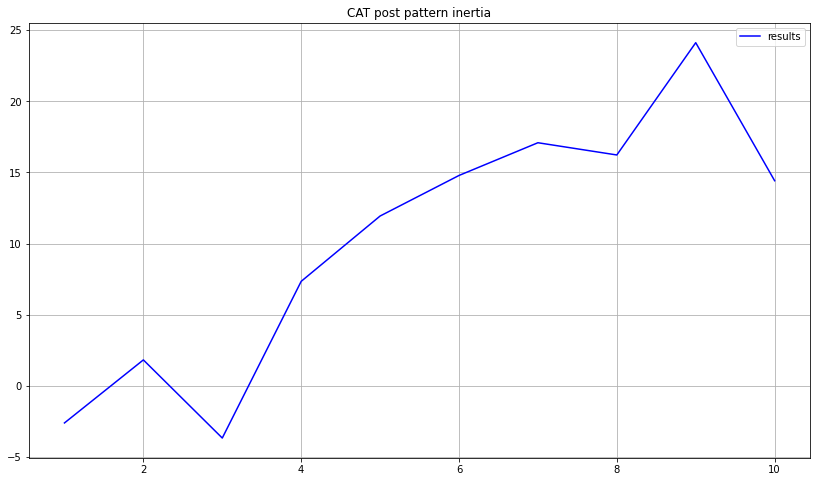


Pattern analysis on: CVX

Occurrences: 15 

DatetimeIndex(['2007-06-11', '2008-01-22', '2008-06-23', '2009-10-05',
               '2012-09-06', '2013-02-27', '2014-10-16', '2015-07-28',
               '2016-08-03', '2017-05-19', '2017-06-06', '2018-05-30',
               '2019-04-16', '2019-06-03', '2020-08-03'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 5.22 average of 0.35 with 11 winning trades and 4 loosing trades
After: 2 days: 8.58 average of 0.57 with 10 winning trades and 5 loosing trades
After: 3 days: 13.55 average of 0.9 with 10 winning trades and 5 loosing trades
After: 4 days: 15.27 average of 1.02 with 10 winning trades and 5 loosing trades
After: 5 days: 21.06 average of 1.4 with 10 winning trades and 5 loosing trades
After: 6 days: 22.3 average of 1.49 with 12 winning trades and 3 loosing trades
After: 7 days: 18.61 average of 1.24 with 10 winning trades and 5 loosing trades
After: 8 days: 27.81 average of 1.85 with 12 winning trade

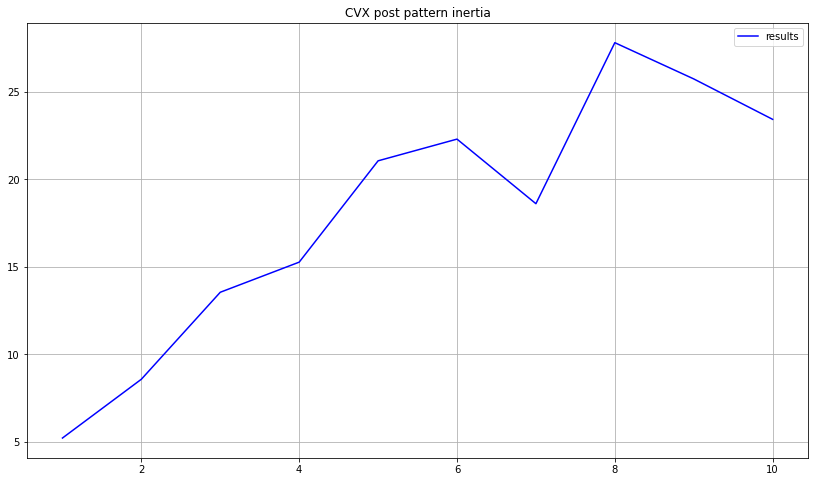


Pattern analysis on: CSCO

Occurrences: 10 

DatetimeIndex(['2009-08-19', '2013-09-30', '2013-10-10', '2014-03-18',
               '2014-08-04', '2016-11-07', '2017-07-05', '2018-04-04',
               '2020-09-25', '2020-10-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.45 average of 0.04 with 4 winning trades and 6 loosing trades
After: 2 days: 1.21 average of 0.12 with 5 winning trades and 5 loosing trades
After: 3 days: 0.73 average of 0.07 with 5 winning trades and 5 loosing trades
After: 4 days: 2.48 average of 0.25 with 6 winning trades and 4 loosing trades
After: 5 days: 2.8 average of 0.28 with 7 winning trades and 3 loosing trades
After: 6 days: 4.9 average of 0.49 with 7 winning trades and 3 loosing trades
After: 7 days: 4.8 average of 0.48 with 7 winning trades and 3 loosing trades
After: 8 days: 1.44 average of 0.14 with 5 winning trades and 4 loosing trades
After: 9 days: 2.69 average of 0.27 with 4 winning trades and 5 loosing tra

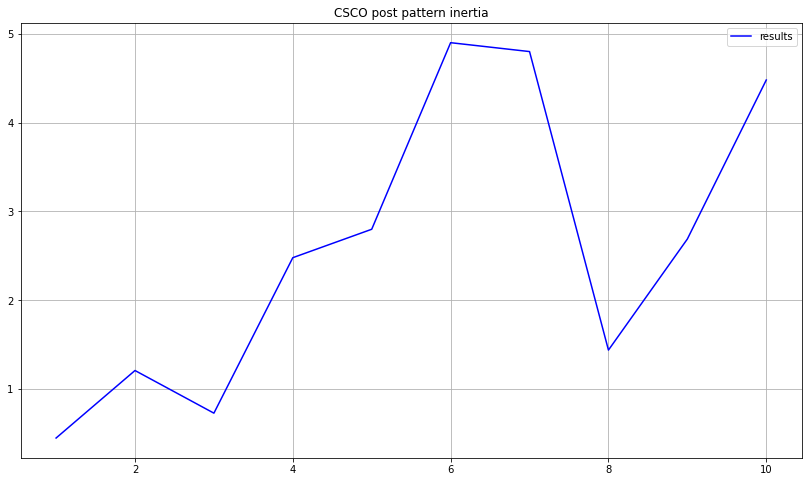


Pattern analysis on: KO

Occurrences: 9 

DatetimeIndex(['2008-06-20', '2009-02-12', '2011-01-10', '2014-12-17',
               '2016-09-15', '2018-05-04', '2018-09-05', '2019-10-04',
               '2020-03-02'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.29 average of -0.14 with 2 winning trades and 7 loosing trades
After: 2 days: 0.03 average of 0.0 with 3 winning trades and 6 loosing trades
After: 3 days: -0.36 average of -0.04 with 5 winning trades and 4 loosing trades
After: 4 days: -1.1 average of -0.12 with 3 winning trades and 6 loosing trades
After: 5 days: -5.03 average of -0.56 with 4 winning trades and 5 loosing trades
After: 6 days: -4.27 average of -0.47 with 4 winning trades and 5 loosing trades
After: 7 days: -6.71 average of -0.75 with 2 winning trades and 7 loosing trades
After: 8 days: -11.43 average of -1.27 with 3 winning trades and 6 loosing trades
After: 9 days: -10.8 average of -1.2 with 2 winning trades and 7 loosing tra

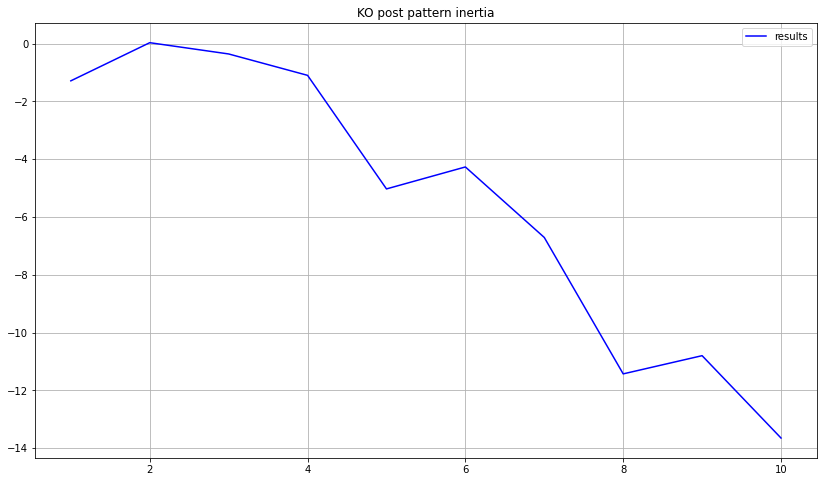


Pattern analysis on: XOM

Occurrences: 8 

DatetimeIndex(['2008-06-05', '2009-08-19', '2012-04-12', '2014-08-04',
               '2015-07-28', '2017-06-06', '2020-08-28', '2020-09-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.51 average of -0.44 with 3 winning trades and 5 loosing trades
After: 2 days: -0.02 average of -0.0 with 3 winning trades and 5 loosing trades
After: 3 days: -1.57 average of -0.2 with 3 winning trades and 5 loosing trades
After: 4 days: -1.33 average of -0.17 with 4 winning trades and 4 loosing trades
After: 5 days: -4.71 average of -0.59 with 3 winning trades and 5 loosing trades
After: 6 days: -5.17 average of -0.65 with 3 winning trades and 5 loosing trades
After: 7 days: -4.76 average of -0.6 with 3 winning trades and 5 loosing trades
After: 8 days: -5.35 average of -0.67 with 3 winning trades and 5 loosing trades
After: 9 days: -3.55 average of -0.44 with 4 winning trades and 4 loosing trades
After: 10 days: -8.58 a

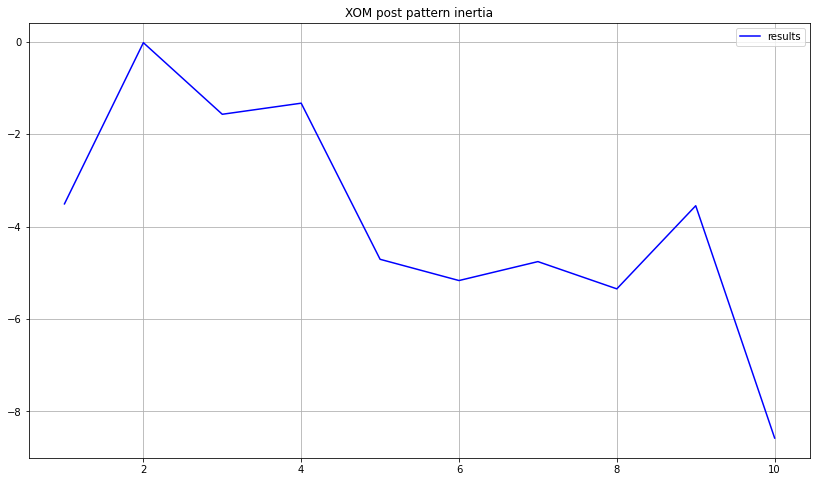


Pattern analysis on: GS

Occurrences: 12 

DatetimeIndex(['2008-07-16', '2009-03-10', '2009-11-03', '2009-11-30',
               '2011-03-18', '2015-03-12', '2015-12-15', '2016-02-04',
               '2017-03-28', '2019-05-15', '2019-06-04', '2019-10-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.21 average of 0.27 with 5 winning trades and 7 loosing trades
After: 2 days: 4.32 average of 0.36 with 5 winning trades and 7 loosing trades
After: 3 days: -13.09 average of -1.09 with 5 winning trades and 7 loosing trades
After: 4 days: 8.81 average of 0.73 with 6 winning trades and 6 loosing trades
After: 5 days: 3.88 average of 0.32 with 6 winning trades and 6 loosing trades
After: 6 days: 5.34 average of 0.44 with 6 winning trades and 6 loosing trades
After: 7 days: 8.14 average of 0.68 with 6 winning trades and 6 loosing trades
After: 8 days: -3.19 average of -0.27 with 5 winning trades and 7 loosing trades
After: 9 days: 12.04 average of 1.0 with 

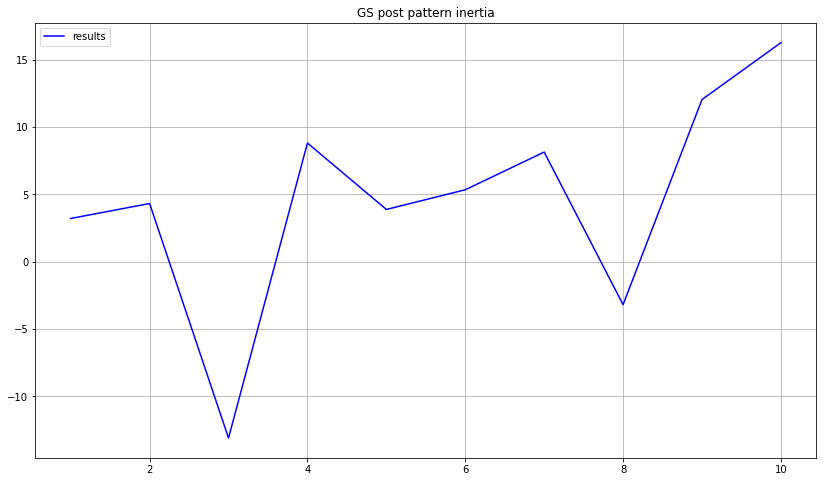


Pattern analysis on: HD

Occurrences: 8 

DatetimeIndex(['2010-08-25', '2012-05-21', '2012-12-17', '2014-04-09',
               '2015-03-27', '2016-05-02', '2016-06-16', '2018-03-05'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.7 average of -0.46 with 1 winning trades and 7 loosing trades
After: 2 days: -8.15 average of -1.02 with 3 winning trades and 5 loosing trades
After: 3 days: -8.95 average of -1.12 with 2 winning trades and 6 loosing trades
After: 4 days: -3.6 average of -0.45 with 3 winning trades and 5 loosing trades
After: 5 days: -2.28 average of -0.28 with 4 winning trades and 4 loosing trades
After: 6 days: -4.16 average of -0.52 with 3 winning trades and 5 loosing trades
After: 7 days: -7.88 average of -0.98 with 4 winning trades and 4 loosing trades
After: 8 days: -6.1 average of -0.76 with 3 winning trades and 5 loosing trades
After: 9 days: -4.79 average of -0.6 with 4 winning trades and 4 loosing trades
After: 10 days: -1.92 ave

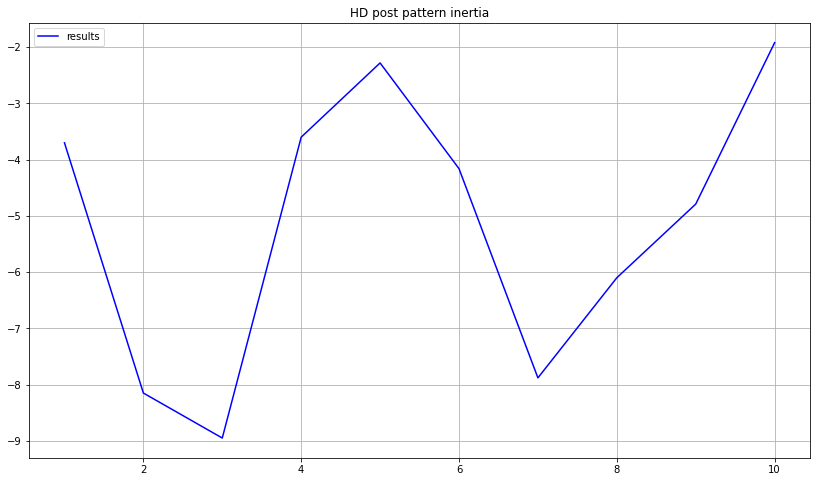


Pattern analysis on: IBM

Occurrences: 11 

DatetimeIndex(['2007-06-08', '2007-11-13', '2008-01-10', '2011-03-03',
               '2015-06-10', '2015-10-22', '2015-12-22', '2016-06-29',
               '2019-10-10', '2020-09-02', '2020-09-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -5.27 average of -0.48 with 5 winning trades and 6 loosing trades
After: 2 days: -8.82 average of -0.8 with 3 winning trades and 8 loosing trades
After: 3 days: -12.84 average of -1.17 with 5 winning trades and 6 loosing trades
After: 4 days: -5.31 average of -0.48 with 6 winning trades and 5 loosing trades
After: 5 days: -17.47 average of -1.59 with 4 winning trades and 7 loosing trades
After: 6 days: -12.8 average of -1.16 with 4 winning trades and 7 loosing trades
After: 7 days: -15.71 average of -1.43 with 4 winning trades and 7 loosing trades
After: 8 days: -8.09 average of -0.74 with 4 winning trades and 7 loosing trades
After: 9 days: -0.28 average of -0.03 wit

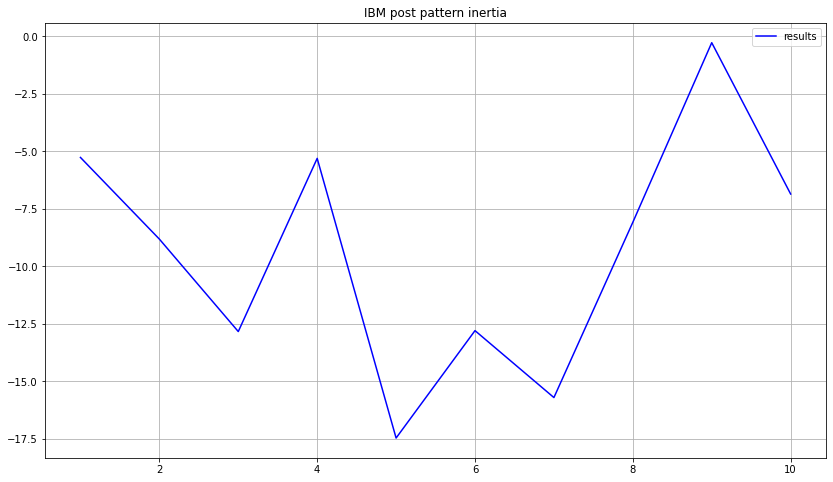


Pattern analysis on: INTC

Occurrences: 9 

DatetimeIndex(['2007-06-08', '2010-02-02', '2011-02-25', '2014-09-16',
               '2014-09-29', '2015-07-28', '2015-12-22', '2016-05-06',
               '2016-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.42 average of 0.05 with 5 winning trades and 4 loosing trades
After: 2 days: -0.52 average of -0.06 with 5 winning trades and 4 loosing trades
After: 3 days: -0.48 average of -0.05 with 2 winning trades and 7 loosing trades
After: 4 days: 1.26 average of 0.14 with 5 winning trades and 4 loosing trades
After: 5 days: 2.14 average of 0.24 with 4 winning trades and 5 loosing trades
After: 6 days: 2.18 average of 0.24 with 4 winning trades and 5 loosing trades
After: 7 days: 1.99 average of 0.22 with 4 winning trades and 5 loosing trades
After: 8 days: 2.02 average of 0.22 with 3 winning trades and 6 loosing trades
After: 9 days: 0.9 average of 0.1 with 4 winning trades and 5 loosing trades
After:

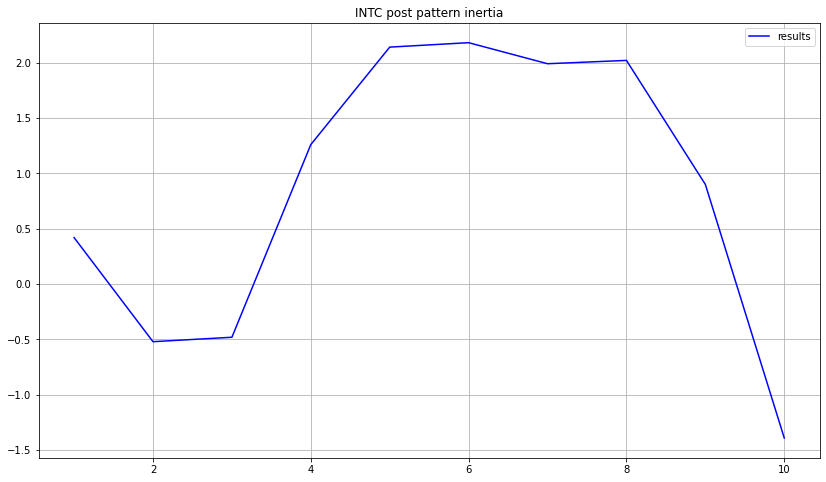


Pattern analysis on: JNJ

Occurrences: 9 

DatetimeIndex(['2008-03-04', '2008-09-08', '2008-10-13', '2009-03-04',
               '2010-01-27', '2011-02-01', '2011-06-28', '2015-02-03',
               '2018-05-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -4.18 average of -0.46 with 4 winning trades and 5 loosing trades
After: 2 days: -8.38 average of -0.93 with 3 winning trades and 6 loosing trades
After: 3 days: -7.39 average of -0.82 with 2 winning trades and 7 loosing trades
After: 4 days: -6.04 average of -0.67 with 4 winning trades and 5 loosing trades
After: 5 days: -1.9 average of -0.21 with 4 winning trades and 5 loosing trades
After: 6 days: -3.11 average of -0.35 with 4 winning trades and 5 loosing trades
After: 7 days: -6.91 average of -0.77 with 5 winning trades and 4 loosing trades
After: 8 days: -3.93 average of -0.44 with 4 winning trades and 5 loosing trades
After: 9 days: -5.68 average of -0.63 with 4 winning trades and 5 loosing

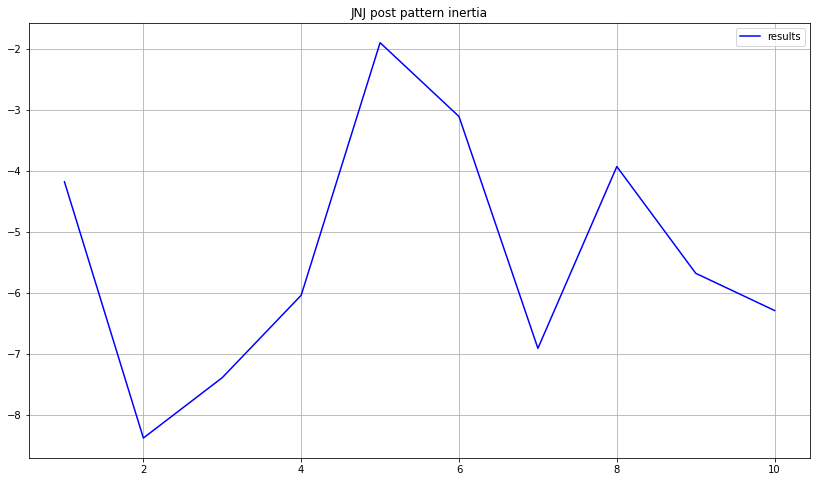


Pattern analysis on: JPM

Occurrences: 13 

DatetimeIndex(['2008-07-16', '2009-11-03', '2011-05-17', '2011-09-07',
               '2011-09-23', '2014-07-10', '2014-10-03', '2014-12-17',
               '2015-08-10', '2018-03-29', '2018-10-16', '2019-10-04',
               '2020-09-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 4.14 average of 0.32 with 8 winning trades and 5 loosing trades
After: 2 days: -1.15 average of -0.09 with 7 winning trades and 6 loosing trades
After: 3 days: 2.1 average of 0.16 with 7 winning trades and 6 loosing trades
After: 4 days: 7.21 average of 0.55 with 8 winning trades and 5 loosing trades
After: 5 days: 4.68 average of 0.36 with 7 winning trades and 6 loosing trades
After: 6 days: 2.51 average of 0.19 with 7 winning trades and 6 loosing trades
After: 7 days: 9.09 average of 0.7 with 8 winning trades and 5 loosing trades
After: 8 days: 1.41 average of 0.11 with 6 winning trades and 7 loosing trades
After: 9 days: 1

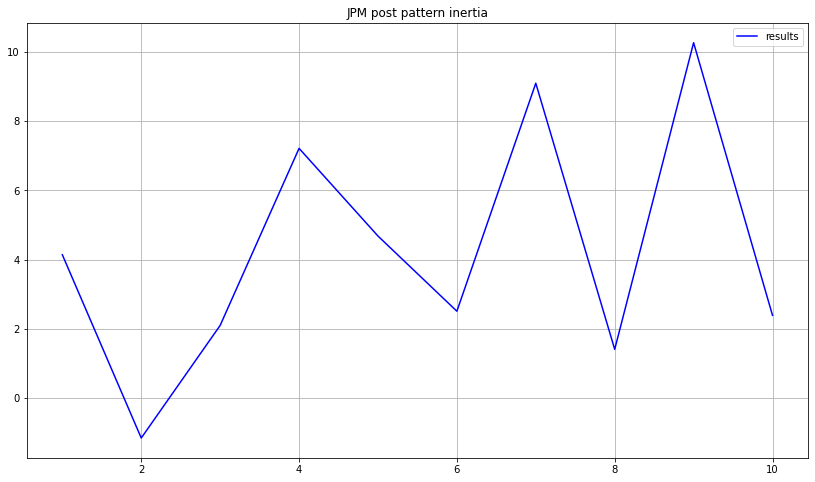


Pattern analysis on: MCD

Occurrences: 10 

DatetimeIndex(['2008-09-08', '2013-06-03', '2013-06-07', '2013-07-25',
               '2014-01-31', '2014-12-17', '2017-09-28', '2018-04-26',
               '2019-09-17', '2020-03-02'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.79 average of -0.38 with 4 winning trades and 6 loosing trades
After: 2 days: 9.45 average of 0.94 with 5 winning trades and 5 loosing trades
After: 3 days: -1.19 average of -0.12 with 4 winning trades and 6 loosing trades
After: 4 days: 2.23 average of 0.22 with 7 winning trades and 3 loosing trades
After: 5 days: -6.34 average of -0.63 with 8 winning trades and 2 loosing trades
After: 6 days: 12.7 average of 1.27 with 8 winning trades and 2 loosing trades
After: 7 days: 1.65 average of 0.16 with 7 winning trades and 3 loosing trades
After: 8 days: -16.4 average of -1.64 with 8 winning trades and 2 loosing trades
After: 9 days: -8.61 average of -0.86 with 8 winning trades and 2

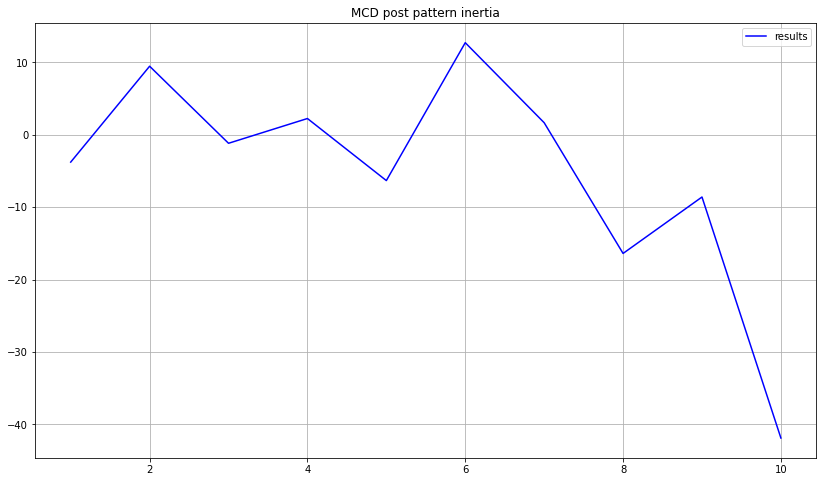


Pattern analysis on: MSFT

Occurrences: 6 

DatetimeIndex(['2008-03-04', '2011-02-07', '2012-04-12', '2015-03-13',
               '2015-06-10', '2017-12-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.29 average of 0.05 with 3 winning trades and 3 loosing trades
After: 2 days: 1.04 average of 0.17 with 3 winning trades and 3 loosing trades
After: 3 days: 2.61 average of 0.44 with 4 winning trades and 2 loosing trades
After: 4 days: 2.73 average of 0.46 with 4 winning trades and 2 loosing trades
After: 5 days: 4.31 average of 0.72 with 4 winning trades and 2 loosing trades
After: 6 days: 4.87 average of 0.81 with 5 winning trades and 1 loosing trades
After: 7 days: 6.2 average of 1.03 with 4 winning trades and 2 loosing trades
After: 8 days: 3.75 average of 0.62 with 3 winning trades and 3 loosing trades
After: 9 days: 3.1 average of 0.52 with 3 winning trades and 3 loosing trades
After: 10 days: 2.84 average of 0.47 with 3 winning trades and 3 lo

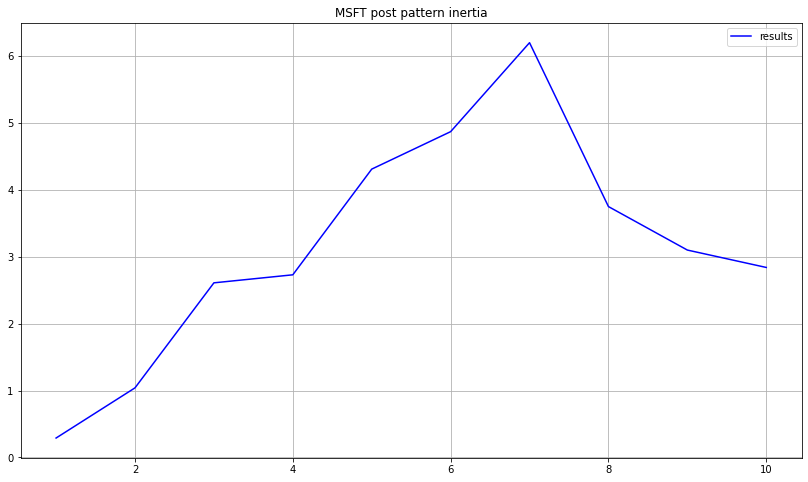


Pattern analysis on: NKE

Occurrences: 7 

DatetimeIndex(['2009-12-11', '2012-06-05', '2015-02-03', '2016-01-05',
               '2017-05-19', '2019-06-04', '2019-08-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.38 average of 0.2 with 5 winning trades and 2 loosing trades
After: 2 days: 2.34 average of 0.33 with 6 winning trades and 1 loosing trades
After: 3 days: 0.58 average of 0.08 with 5 winning trades and 2 loosing trades
After: 4 days: -0.38 average of -0.05 with 4 winning trades and 3 loosing trades
After: 5 days: 3.73 average of 0.53 with 5 winning trades and 2 loosing trades
After: 6 days: -1.97 average of -0.28 with 4 winning trades and 3 loosing trades
After: 7 days: -2.87 average of -0.41 with 3 winning trades and 4 loosing trades
After: 8 days: -3.36 average of -0.48 with 3 winning trades and 4 loosing trades
After: 9 days: -2.63 average of -0.38 with 3 winning trades and 4 loosing trades
After: 10 days: 0.7 average of 0.1 with 5 w

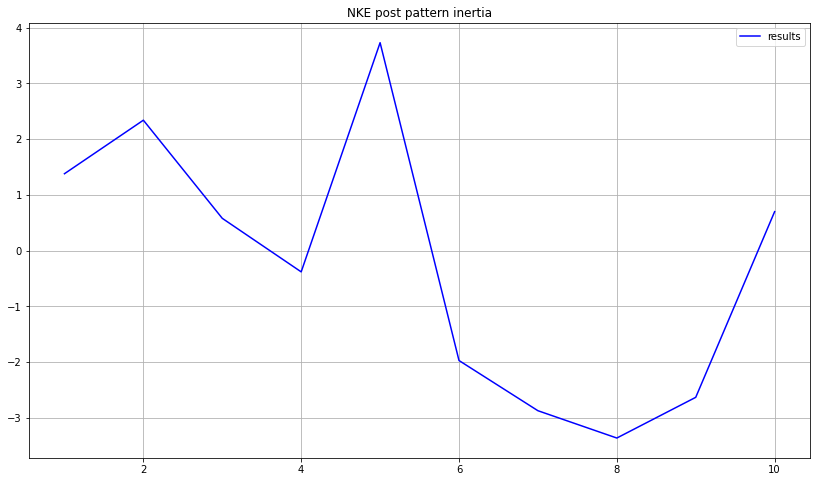


Basket analysis:
Positive inertia after 1 bars: ['MMM', 'AXP', 'BA', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MSFT', 'NKE']
Positive inertia after 2 bars: ['MMM', 'AAPL', 'CAT', 'CVX', 'CSCO', 'KO', 'GS', 'MCD', 'MSFT', 'NKE']
Positive inertia after 3 bars: ['MMM', 'AXP', 'AAPL', 'CVX', 'CSCO', 'JPM', 'MSFT', 'NKE']
Positive inertia after 4 bars: ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MCD', 'MSFT']
Positive inertia after 5 bars: ['MMM', 'AXP', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MSFT', 'NKE']
Positive inertia after 6 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MCD', 'MSFT']
Positive inertia after 7 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MCD', 'MSFT']
Positive inertia after 8 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'CVX', 'CSCO', 'INTC', 'JPM', 'MSFT']
Positive inertia after 9 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JPM', 'MSFT']
Positive inertia after 10 bars: ['M

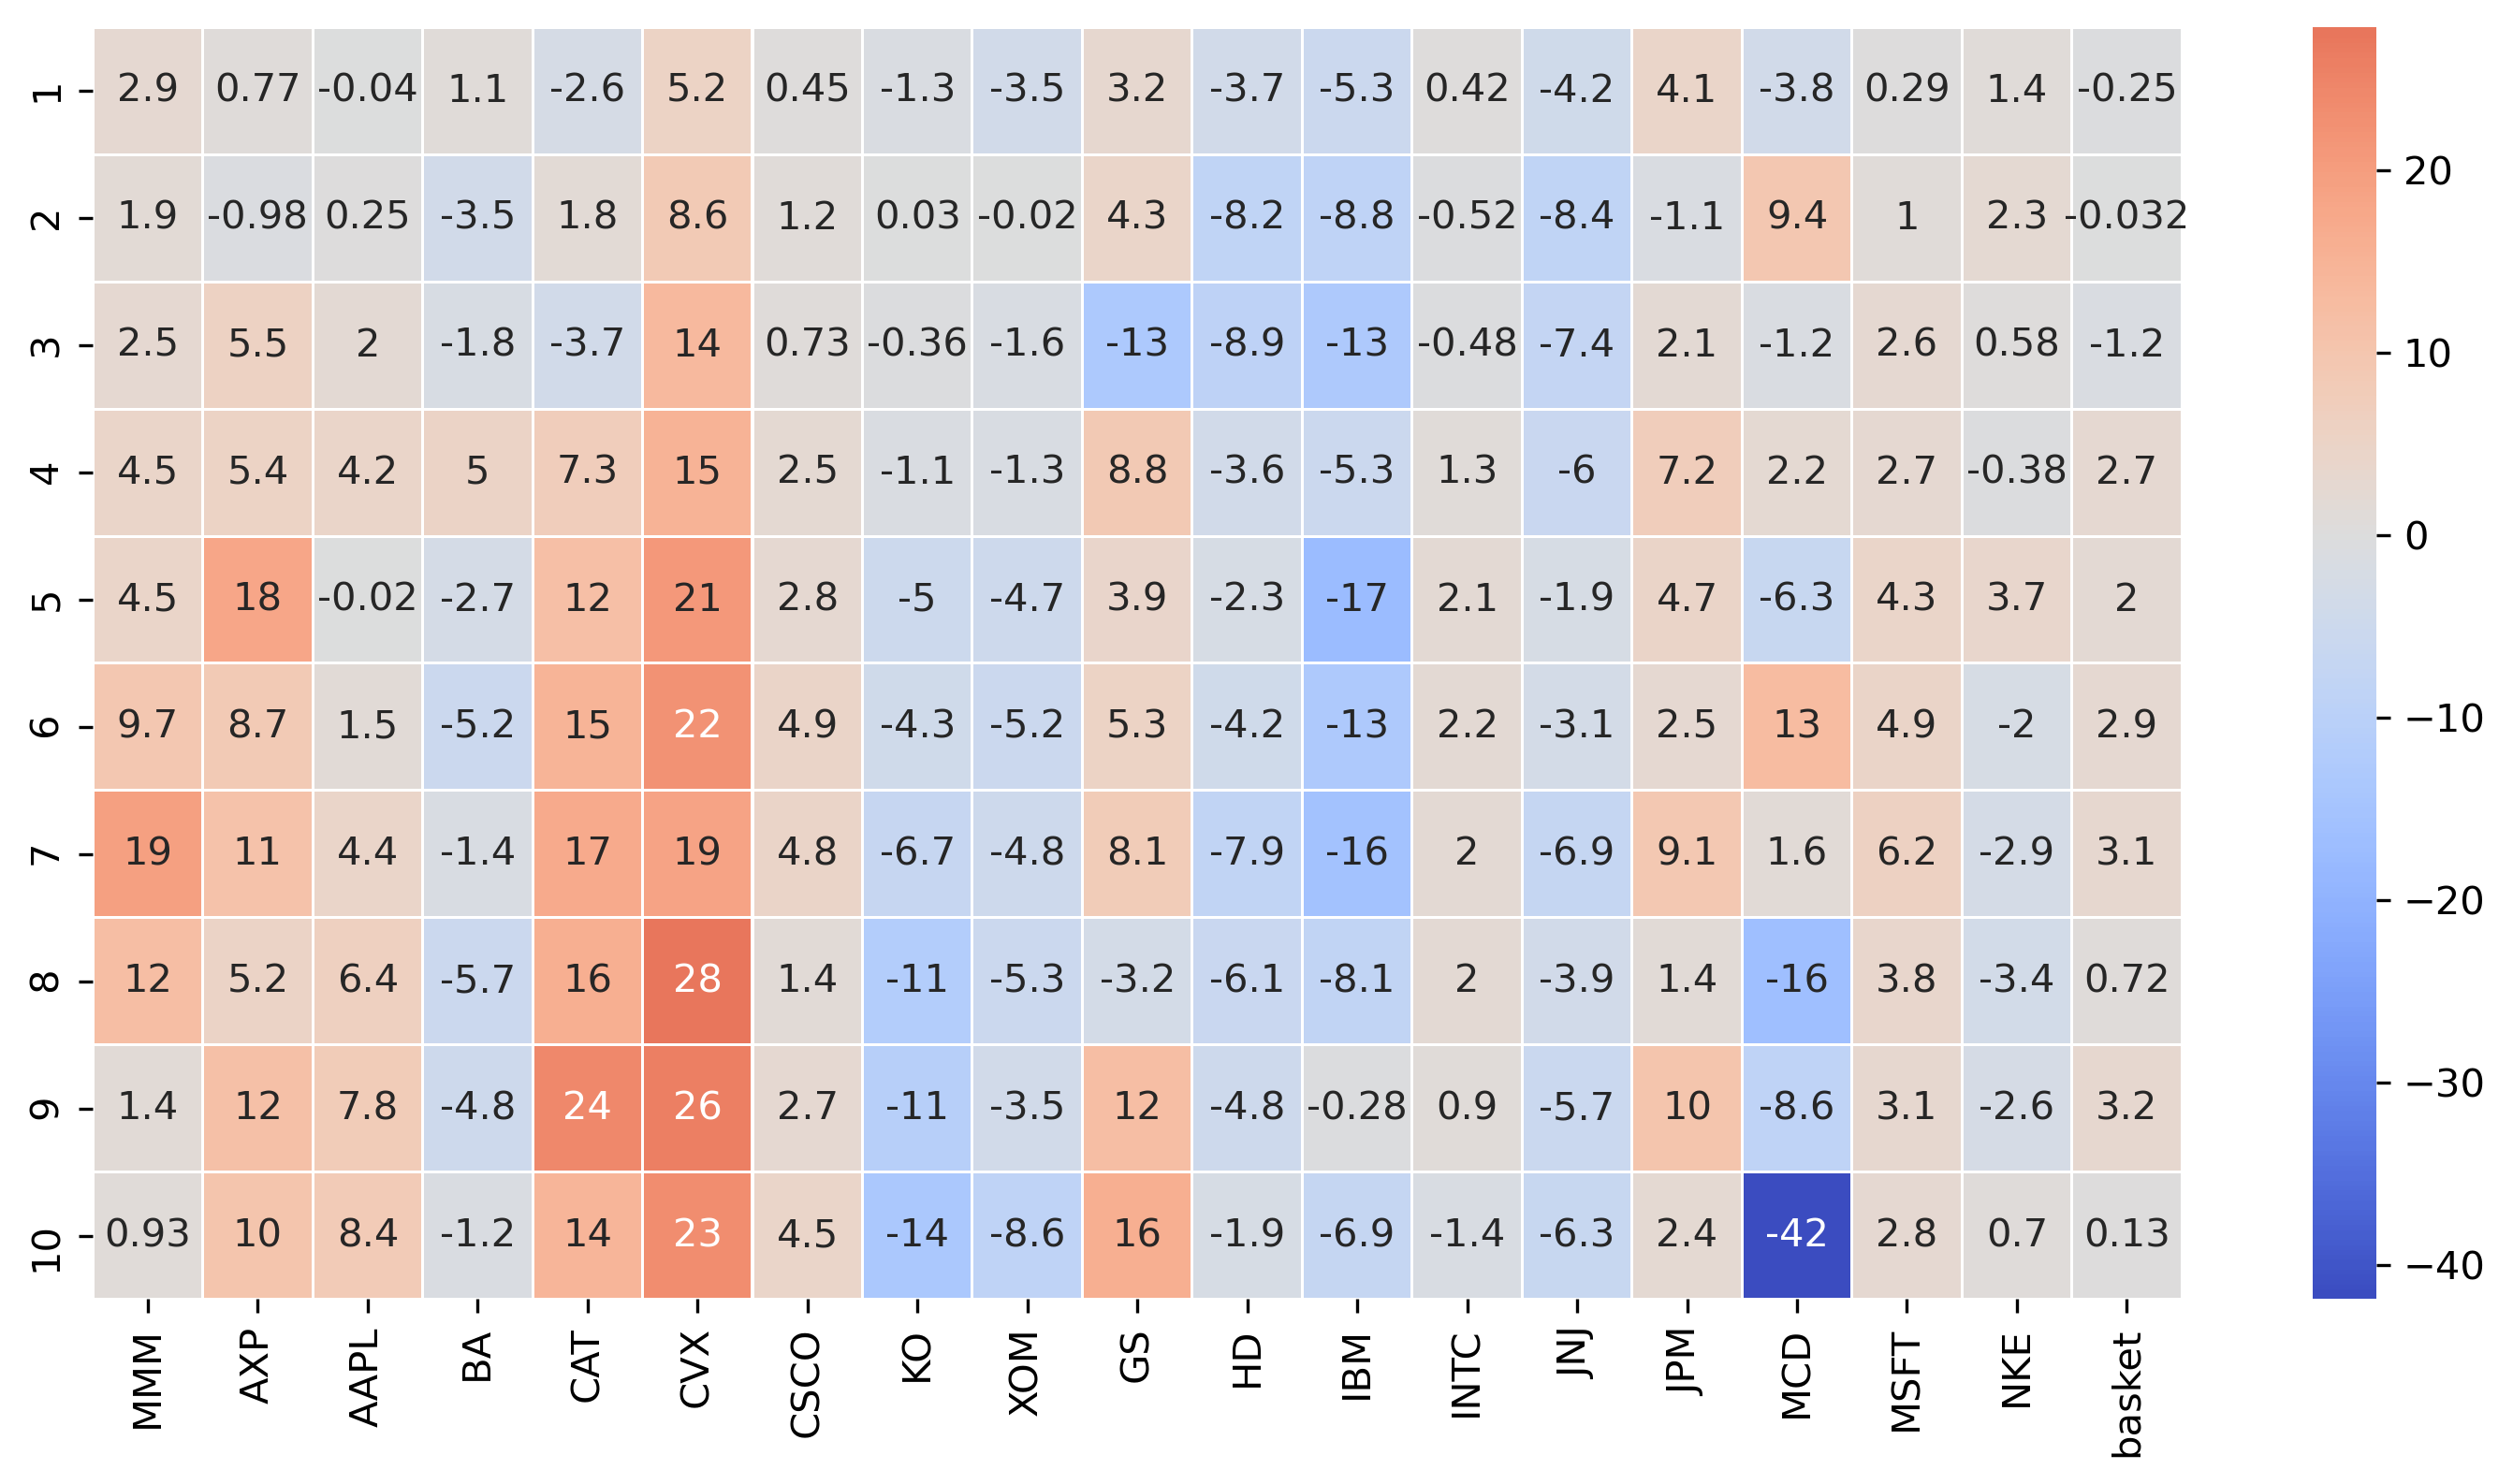

In [9]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = ((dataset.low.shift(1) < dataset.BBL.shift(1))) & \
               (dataset.close > dataset.open) & (dataset.close.shift(2) < dataset.open.shift(2)) & \
               (dataset.close_pos > 70) & (dataset.open_pos < 30) &\
               (dataset.close_pos.shift(2) < 30) & (dataset.open_pos.shift(2) > 70) & \
               (dataset.range_perc > 1) & (dataset.range_perc.shift(2) > 1) & (dataset.body_perc.shift(1) < 1)
    
    results = pattern_stats(dataset, pattern, "long", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [10]:
basket_results.iplot(title = "Pattern inertia")

# <span style="color:red">Esempio "Evening Star"</span>

Pattern analysis on: MMM

Occurrences: 11 

DatetimeIndex(['2007-12-11', '2009-11-12', '2011-01-28', '2011-05-02',
               '2013-09-20', '2014-05-02', '2016-11-14', '2017-12-04',
               '2018-01-30', '2018-07-30', '2020-09-15'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -5.56 average of -0.51 with 5 winning trades and 6 loosing trades
After: 2 days: 2.65 average of 0.24 with 7 winning trades and 4 loosing trades
After: 3 days: 7.68 average of 0.7 with 7 winning trades and 4 loosing trades
After: 4 days: 29.92 average of 2.72 with 6 winning trades and 5 loosing trades
After: 5 days: 27.29 average of 2.48 with 8 winning trades and 3 loosing trades
After: 6 days: 31.66 average of 2.88 with 8 winning trades and 3 loosing trades
After: 7 days: 38.65 average of 3.51 with 8 winning trades and 3 loosing trades
After: 8 days: 36.0 average of 3.27 with 7 winning trades and 4 loosing trades
After: 9 days: 36.24 average of 3.29 with 8 winning tra

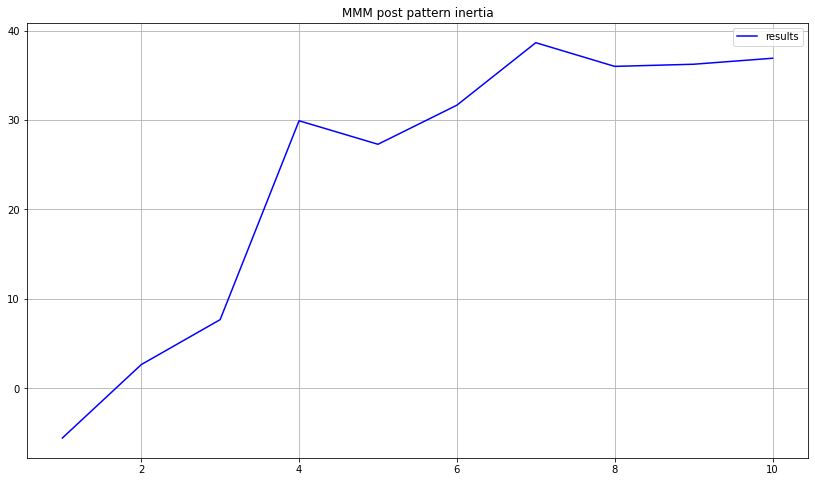


Pattern analysis on: AXP

Occurrences: 10 

DatetimeIndex(['2007-07-20', '2007-09-20', '2009-11-12', '2012-06-21',
               '2015-03-24', '2016-04-15', '2016-08-09', '2017-08-17',
               '2018-11-12', '2019-03-19'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.04 average of 0.3 with 7 winning trades and 3 loosing trades
After: 2 days: 6.1 average of 0.61 with 6 winning trades and 4 loosing trades
After: 3 days: 4.81 average of 0.48 with 7 winning trades and 3 loosing trades
After: 4 days: 4.78 average of 0.48 with 5 winning trades and 5 loosing trades
After: 5 days: 7.16 average of 0.72 with 7 winning trades and 3 loosing trades
After: 6 days: 6.07 average of 0.61 with 6 winning trades and 4 loosing trades
After: 7 days: 3.12 average of 0.31 with 5 winning trades and 5 loosing trades
After: 8 days: 2.62 average of 0.26 with 5 winning trades and 5 loosing trades
After: 9 days: -2.77 average of -0.28 with 6 winning trades and 4 loosing t

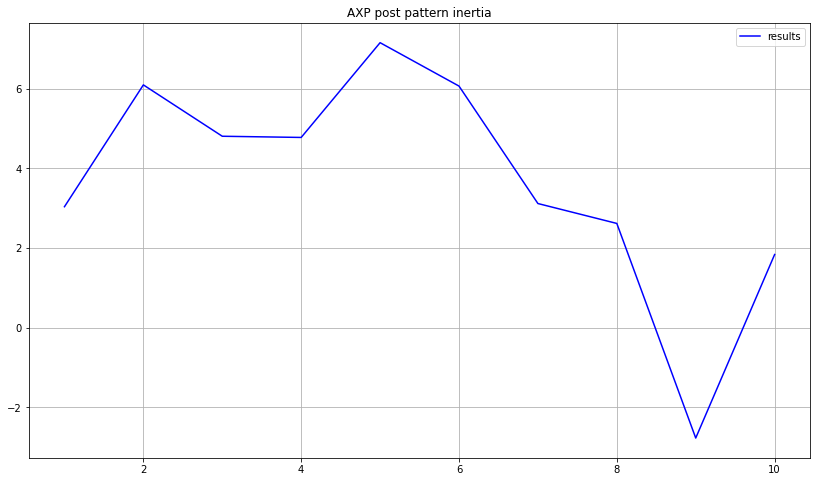


Pattern analysis on: AAPL

Occurrences: 10 

DatetimeIndex(['2007-06-01', '2007-07-09', '2009-12-29', '2010-04-27',
               '2011-09-21', '2013-03-26', '2013-12-05', '2018-10-04',
               '2019-10-02', '2020-06-17'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.31 average of 0.03 with 4 winning trades and 6 loosing trades
After: 2 days: -0.85 average of -0.08 with 3 winning trades and 7 loosing trades
After: 3 days: -3.31 average of -0.33 with 4 winning trades and 6 loosing trades
After: 4 days: -2.02 average of -0.2 with 4 winning trades and 6 loosing trades
After: 5 days: -0.18 average of -0.02 with 5 winning trades and 5 loosing trades
After: 6 days: -3.22 average of -0.32 with 5 winning trades and 5 loosing trades
After: 7 days: -0.05 average of -0.0 with 5 winning trades and 5 loosing trades
After: 8 days: -2.51 average of -0.25 with 6 winning trades and 4 loosing trades
After: 9 days: -3.43 average of -0.34 with 6 winning trades 

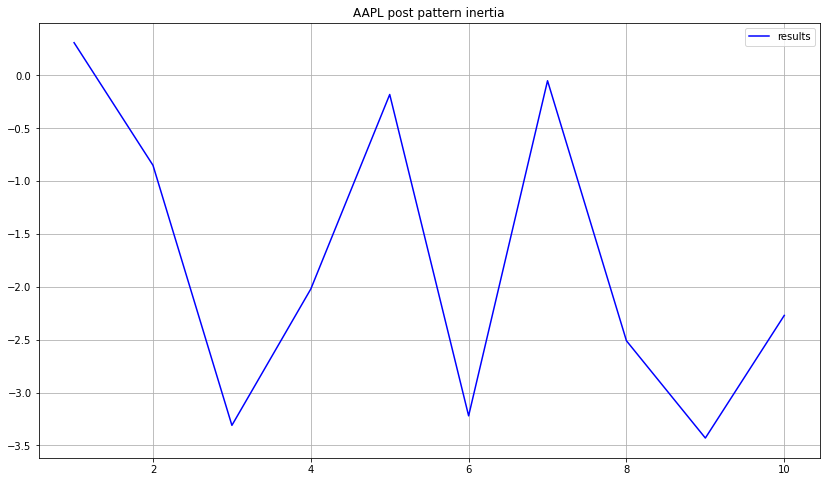


Pattern analysis on: BA

Occurrences: 7 

DatetimeIndex(['2007-06-01', '2010-01-11', '2011-04-25', '2013-10-21',
               '2016-07-28', '2019-03-01', '2019-08-26'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 14.55 average of 2.08 with 3 winning trades and 4 loosing trades
After: 2 days: 4.97 average of 0.71 with 2 winning trades and 5 loosing trades
After: 3 days: 7.89 average of 1.13 with 3 winning trades and 4 loosing trades
After: 4 days: 6.92 average of 0.99 with 3 winning trades and 4 loosing trades
After: 5 days: 17.65 average of 2.52 with 4 winning trades and 3 loosing trades
After: 6 days: 38.88 average of 5.55 with 4 winning trades and 3 loosing trades
After: 7 days: 61.97 average of 8.85 with 4 winning trades and 3 loosing trades
After: 8 days: 56.12 average of 8.02 with 4 winning trades and 3 loosing trades
After: 9 days: 60.62 average of 8.66 with 5 winning trades and 2 loosing trades
After: 10 days: 44.3 average of 6.33 with 4 win

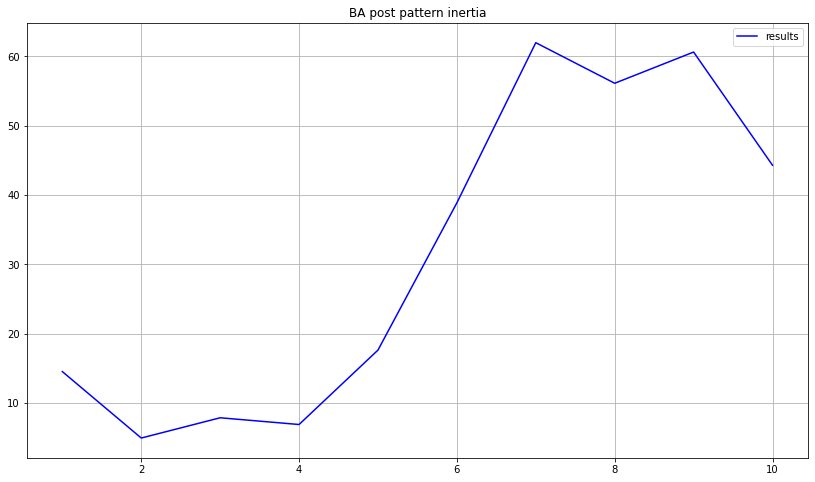


Pattern analysis on: CAT

Occurrences: 12 

DatetimeIndex(['2007-06-20', '2008-02-04', '2009-05-07', '2011-01-20',
               '2012-11-07', '2013-08-14', '2016-09-23', '2016-10-04',
               '2017-06-20', '2018-07-30', '2019-07-17', '2019-12-16'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 2.28 average of 0.19 with 4 winning trades and 8 loosing trades
After: 2 days: 3.61 average of 0.3 with 7 winning trades and 5 loosing trades
After: 3 days: 5.21 average of 0.43 with 8 winning trades and 4 loosing trades
After: 4 days: 2.13 average of 0.18 with 7 winning trades and 5 loosing trades
After: 5 days: 7.77 average of 0.65 with 9 winning trades and 3 loosing trades
After: 6 days: 0.64 average of 0.05 with 7 winning trades and 5 loosing trades
After: 7 days: 1.97 average of 0.16 with 8 winning trades and 4 loosing trades
After: 8 days: -6.06 average of -0.5 with 7 winning trades and 5 loosing trades
After: 9 days: 3.2 average of 0.27 with 7 win

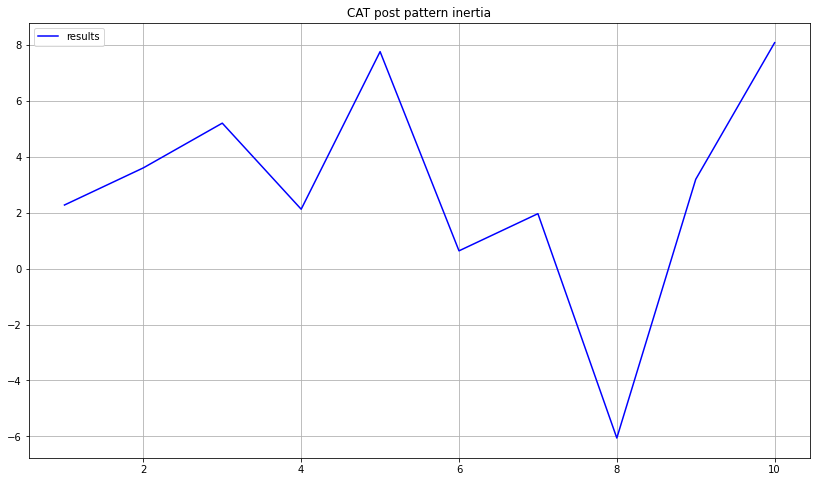


Pattern analysis on: CVX

Occurrences: 12 

DatetimeIndex(['2007-07-16', '2008-08-25', '2009-02-10', '2009-11-12',
               '2017-08-03', '2017-09-08', '2018-07-11', '2018-07-31',
               '2018-09-26', '2018-12-04', '2019-03-07', '2019-11-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.87 average of -0.24 with 4 winning trades and 8 loosing trades
After: 2 days: -3.17 average of -0.26 with 4 winning trades and 8 loosing trades
After: 3 days: -6.93 average of -0.58 with 6 winning trades and 6 loosing trades
After: 4 days: -3.54 average of -0.3 with 5 winning trades and 7 loosing trades
After: 5 days: -1.19 average of -0.1 with 5 winning trades and 7 loosing trades
After: 6 days: 1.78 average of 0.15 with 7 winning trades and 5 loosing trades
After: 7 days: 5.78 average of 0.48 with 8 winning trades and 4 loosing trades
After: 8 days: 17.01 average of 1.42 with 8 winning trades and 4 loosing trades
After: 9 days: 18.92 average of 1.58

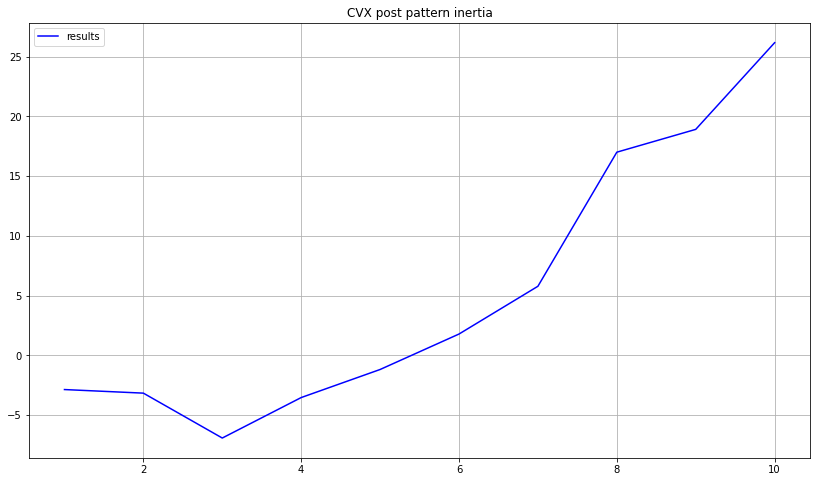


Pattern analysis on: CSCO

Occurrences: 3 

DatetimeIndex(['2015-05-20', '2017-09-27', '2018-08-21'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.01 average of 0.0 with 1 winning trades and 2 loosing trades
After: 2 days: -0.13 average of -0.04 with 1 winning trades and 2 loosing trades
After: 3 days: -0.24 average of -0.08 with 1 winning trades and 2 loosing trades
After: 4 days: -0.97 average of -0.32 with 1 winning trades and 2 loosing trades
After: 5 days: -0.96 average of -0.32 with 1 winning trades and 2 loosing trades
After: 6 days: -1.6 average of -0.53 with 1 winning trades and 2 loosing trades
After: 7 days: -1.3 average of -0.43 with 1 winning trades and 2 loosing trades
After: 8 days: -1.83 average of -0.61 with 1 winning trades and 2 loosing trades
After: 9 days: -1.59 average of -0.53 with 1 winning trades and 2 loosing trades
After: 10 days: -0.69 average of -0.23 with 1 winning trades and 2 loosing trades


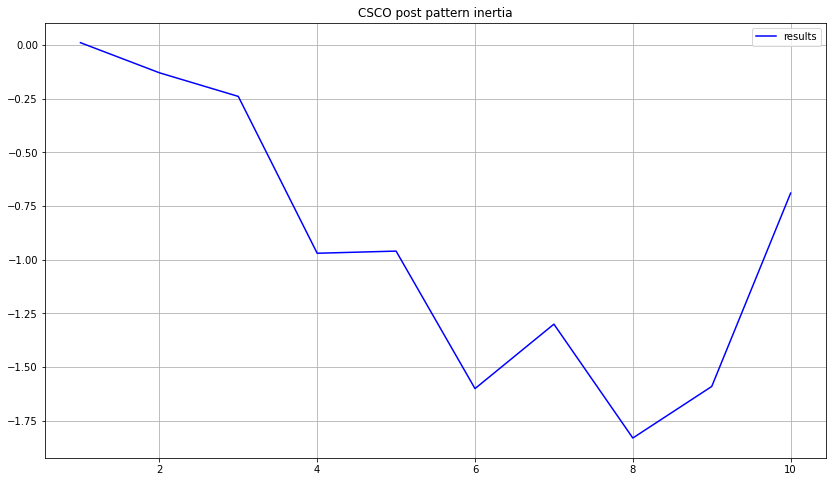


Pattern analysis on: KO

Occurrences: 12 

DatetimeIndex(['2007-07-17', '2007-07-27', '2007-10-19', '2007-12-17',
               '2008-01-11', '2008-08-07', '2009-09-21', '2012-07-05',
               '2013-05-29', '2015-01-23', '2015-12-18', '2019-01-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.41 average of 0.03 with 7 winning trades and 5 loosing trades
After: 2 days: 1.08 average of 0.09 with 6 winning trades and 6 loosing trades
After: 3 days: 0.5 average of 0.04 with 7 winning trades and 5 loosing trades
After: 4 days: -1.74 average of -0.14 with 5 winning trades and 7 loosing trades
After: 5 days: 0.71 average of 0.06 with 6 winning trades and 6 loosing trades
After: 6 days: -1.0 average of -0.08 with 4 winning trades and 8 loosing trades
After: 7 days: -0.17 average of -0.01 with 6 winning trades and 6 loosing trades
After: 8 days: -0.57 average of -0.05 with 7 winning trades and 5 loosing trades
After: 9 days: 1.46 average of 0.12 with

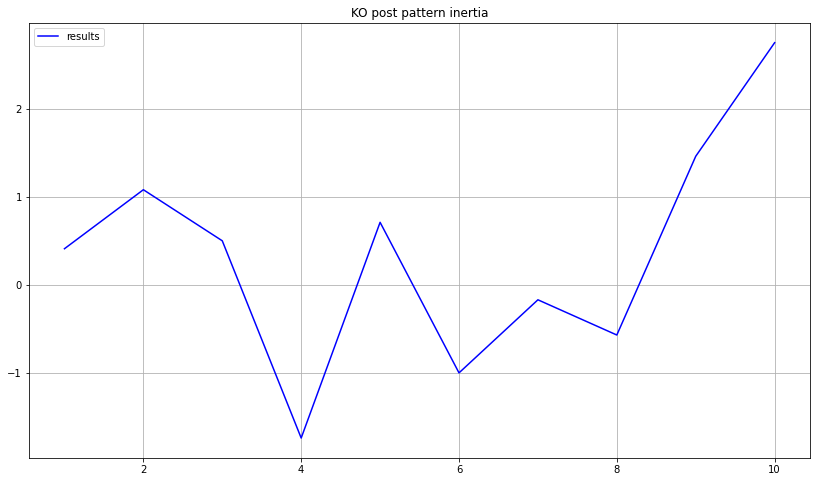


Pattern analysis on: XOM

Occurrences: 10 

DatetimeIndex(['2011-12-28', '2012-10-19', '2013-04-03', '2013-12-20',
               '2013-12-30', '2015-05-05', '2017-03-03', '2018-09-13',
               '2019-04-24', '2020-01-03'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.14 average of -0.21 with 3 winning trades and 7 loosing trades
After: 2 days: 4.6 average of 0.46 with 6 winning trades and 4 loosing trades
After: 3 days: 4.09 average of 0.41 with 7 winning trades and 3 loosing trades
After: 4 days: 2.32 average of 0.23 with 7 winning trades and 3 loosing trades
After: 5 days: 4.13 average of 0.41 with 6 winning trades and 4 loosing trades
After: 6 days: 4.14 average of 0.41 with 6 winning trades and 4 loosing trades
After: 7 days: 5.0 average of 0.5 with 7 winning trades and 3 loosing trades
After: 8 days: 7.25 average of 0.72 with 6 winning trades and 4 loosing trades
After: 9 days: 11.06 average of 1.11 with 7 winning trades and 3 loosing t

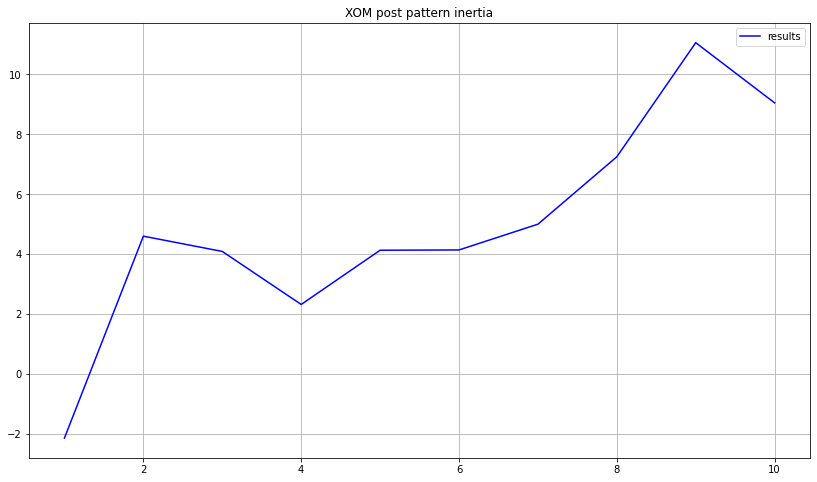


Pattern analysis on: GS

Occurrences: 9 

DatetimeIndex(['2007-09-20', '2008-04-28', '2010-10-22', '2010-11-09',
               '2011-07-27', '2013-09-12', '2015-10-30', '2016-04-15',
               '2017-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -8.85 average of -0.98 with 3 winning trades and 6 loosing trades
After: 2 days: -15.98 average of -1.78 with 2 winning trades and 7 loosing trades
After: 3 days: -26.37 average of -2.93 with 3 winning trades and 6 loosing trades
After: 4 days: -30.94 average of -3.44 with 2 winning trades and 7 loosing trades
After: 5 days: -38.76 average of -4.31 with 3 winning trades and 6 loosing trades
After: 6 days: -25.17 average of -2.8 with 3 winning trades and 6 loosing trades
After: 7 days: -29.46 average of -3.27 with 3 winning trades and 6 loosing trades
After: 8 days: -20.41 average of -2.27 with 4 winning trades and 5 loosing trades
After: 9 days: -20.15 average of -2.24 with 4 winning trades and 5 

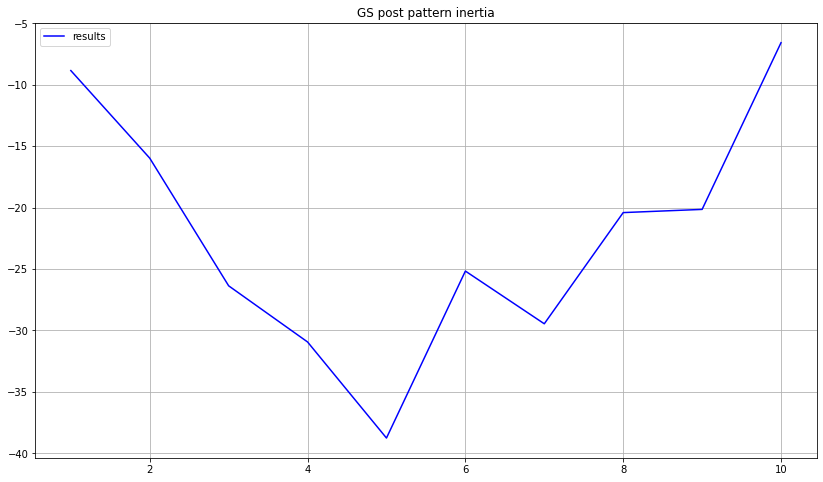


Pattern analysis on: HD

Occurrences: 13 

DatetimeIndex(['2008-01-25', '2010-04-27', '2010-09-07', '2011-01-19',
               '2013-09-20', '2013-11-19', '2015-08-06', '2016-11-14',
               '2017-06-21', '2017-10-30', '2018-04-30', '2019-02-06',
               '2020-05-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.11 average of 0.01 with 6 winning trades and 7 loosing trades
After: 2 days: -4.78 average of -0.37 with 5 winning trades and 8 loosing trades
After: 3 days: -2.28 average of -0.18 with 7 winning trades and 6 loosing trades
After: 4 days: -8.8 average of -0.68 with 4 winning trades and 9 loosing trades
After: 5 days: -9.55 average of -0.73 with 6 winning trades and 7 loosing trades
After: 6 days: -16.02 average of -1.23 with 5 winning trades and 8 loosing trades
After: 7 days: -25.19 average of -1.94 with 6 winning trades and 7 loosing trades
After: 8 days: -33.54 average of -2.58 with 6 winning trades and 7 loosing trades
A

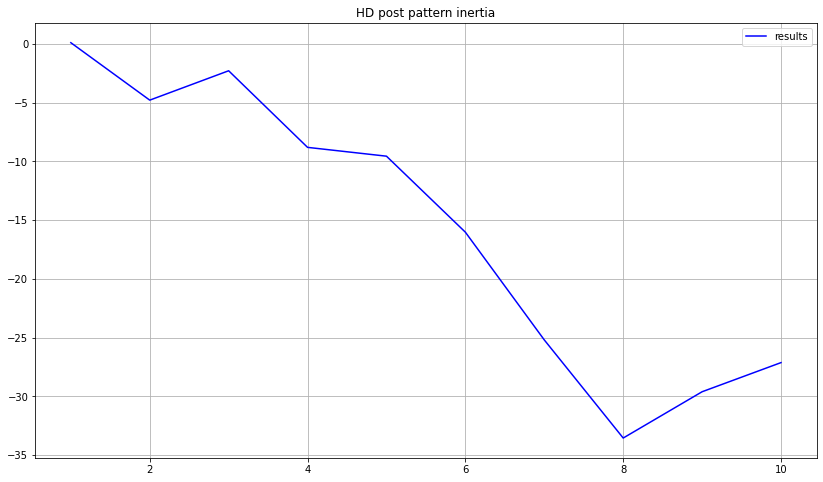


Pattern analysis on: IBM

Occurrences: 9 

DatetimeIndex(['2007-10-03', '2008-05-19', '2011-01-21', '2015-02-23',
               '2015-04-30', '2015-10-12', '2016-11-14', '2018-12-04',
               '2020-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -8.06 average of -0.9 with 4 winning trades and 5 loosing trades
After: 2 days: -1.53 average of -0.17 with 4 winning trades and 5 loosing trades
After: 3 days: -4.07 average of -0.45 with 5 winning trades and 4 loosing trades
After: 4 days: -1.77 average of -0.2 with 5 winning trades and 4 loosing trades
After: 5 days: -5.35 average of -0.59 with 4 winning trades and 5 loosing trades
After: 6 days: -2.51 average of -0.28 with 4 winning trades and 5 loosing trades
After: 7 days: 8.56 average of 0.95 with 4 winning trades and 5 loosing trades
After: 8 days: 9.47 average of 1.05 with 5 winning trades and 4 loosing trades
After: 9 days: 7.47 average of 0.83 with 5 winning trades and 4 loosing trades

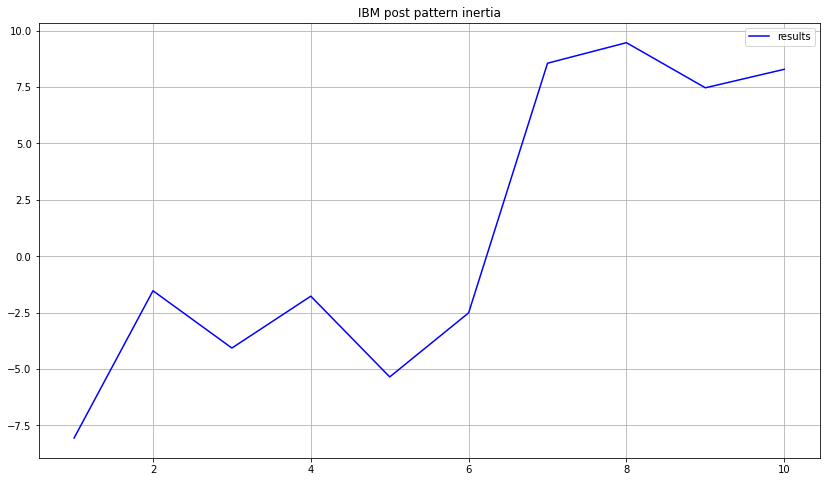


Pattern analysis on: INTC

Occurrences: 11 

DatetimeIndex(['2008-05-19', '2010-07-14', '2011-11-17', '2013-03-08',
               '2015-06-01', '2016-03-03', '2017-01-26', '2017-12-21',
               '2018-12-04', '2019-07-16', '2020-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.89 average of -0.17 with 4 winning trades and 7 loosing trades
After: 2 days: 2.84 average of 0.26 with 7 winning trades and 4 loosing trades
After: 3 days: 2.71 average of 0.25 with 5 winning trades and 6 loosing trades
After: 4 days: 2.47 average of 0.22 with 5 winning trades and 6 loosing trades
After: 5 days: 1.81 average of 0.16 with 7 winning trades and 4 loosing trades
After: 6 days: -2.23 average of -0.2 with 5 winning trades and 6 loosing trades
After: 7 days: 2.13 average of 0.19 with 7 winning trades and 4 loosing trades
After: 8 days: 2.48 average of 0.23 with 6 winning trades and 5 loosing trades
After: 9 days: 0.89 average of 0.08 with 5 winning trad

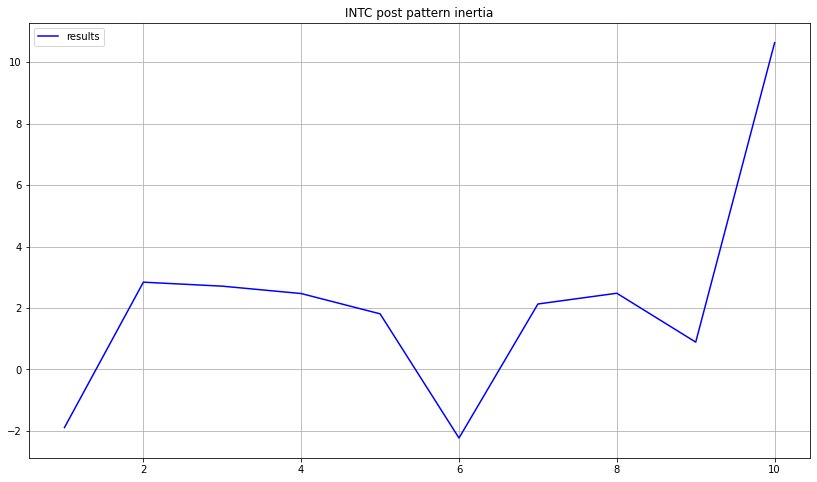


Pattern analysis on: JNJ

Occurrences: 9 

DatetimeIndex(['2010-01-21', '2010-07-09', '2011-12-28', '2012-07-20',
               '2013-04-18', '2015-12-17', '2017-05-17', '2018-03-12',
               '2020-02-07'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.65 average of -0.07 with 4 winning trades and 5 loosing trades
After: 2 days: 2.0 average of 0.22 with 4 winning trades and 5 loosing trades
After: 3 days: -0.02 average of -0.0 with 5 winning trades and 4 loosing trades
After: 4 days: -0.72 average of -0.08 with 4 winning trades and 5 loosing trades
After: 5 days: 1.39 average of 0.15 with 4 winning trades and 5 loosing trades
After: 6 days: 3.44 average of 0.38 with 5 winning trades and 4 loosing trades
After: 7 days: 3.89 average of 0.43 with 5 winning trades and 4 loosing trades
After: 8 days: 8.81 average of 0.98 with 4 winning trades and 5 loosing trades
After: 9 days: 11.91 average of 1.32 with 6 winning trades and 3 loosing trades
Afte

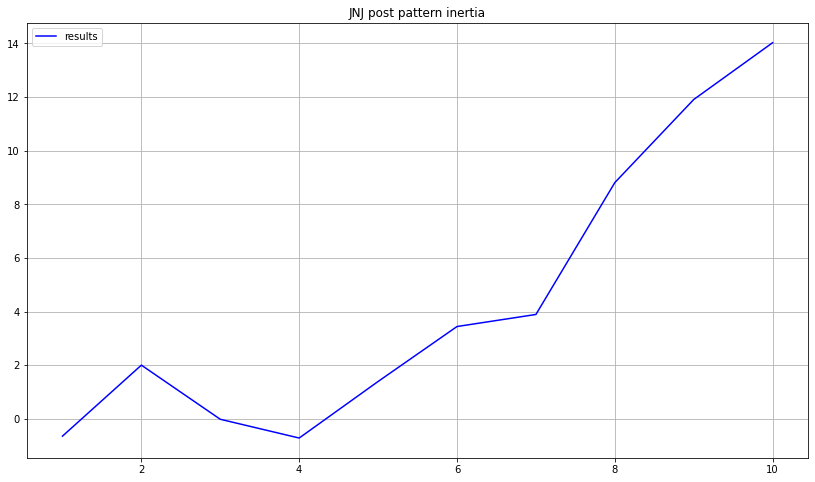


Pattern analysis on: JPM

Occurrences: 13 

DatetimeIndex(['2007-09-20', '2010-01-11', '2010-11-09', '2011-04-08',
               '2014-01-17', '2014-03-26', '2015-10-30', '2015-11-09',
               '2016-05-26', '2017-03-02', '2018-01-19', '2018-09-21',
               '2019-03-19'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.98 average of -0.08 with 6 winning trades and 7 loosing trades
After: 2 days: 3.56 average of 0.27 with 6 winning trades and 7 loosing trades
After: 3 days: 9.0 average of 0.69 with 8 winning trades and 5 loosing trades
After: 4 days: 13.44 average of 1.03 with 8 winning trades and 5 loosing trades
After: 5 days: 12.41 average of 0.95 with 10 winning trades and 3 loosing trades
After: 6 days: 14.11 average of 1.09 with 9 winning trades and 4 loosing trades
After: 7 days: 13.89 average of 1.07 with 10 winning trades and 3 loosing trades
After: 8 days: 13.23 average of 1.02 with 9 winning trades and 4 loosing trades
After: 9

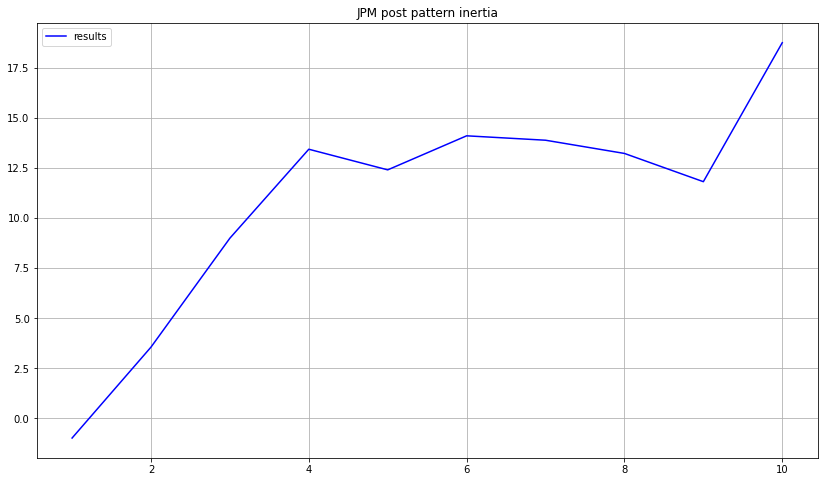


Pattern analysis on: MCD

Occurrences: 8 

DatetimeIndex(['2009-01-06', '2009-08-28', '2009-11-17', '2014-03-13',
               '2018-01-30', '2018-06-11', '2018-10-25', '2019-06-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 2.43 average of 0.3 with 4 winning trades and 4 loosing trades
After: 2 days: 2.13 average of 0.27 with 6 winning trades and 2 loosing trades
After: 3 days: -0.19 average of -0.02 with 4 winning trades and 4 loosing trades
After: 4 days: 7.62 average of 0.95 with 5 winning trades and 3 loosing trades
After: 5 days: 9.51 average of 1.19 with 4 winning trades and 4 loosing trades
After: 6 days: 10.53 average of 1.32 with 4 winning trades and 4 loosing trades
After: 7 days: 16.62 average of 2.08 with 6 winning trades and 2 loosing trades
After: 8 days: 13.1 average of 1.64 with 6 winning trades and 2 loosing trades
After: 9 days: 8.14 average of 1.02 with 6 winning trades and 2 loosing trades
After: 10 days: 12.74 average of 1.

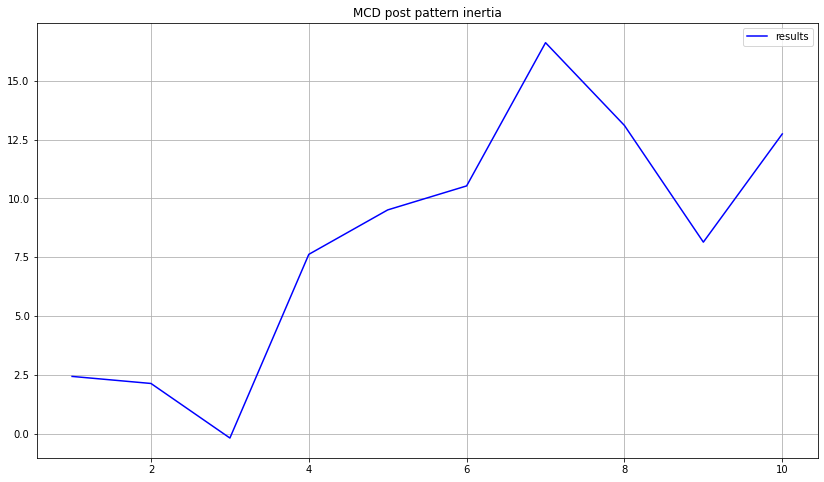


Pattern analysis on: MSFT

Occurrences: 17 

DatetimeIndex(['2007-10-19', '2007-12-17', '2009-04-28', '2011-07-27',
               '2012-03-16', '2013-07-17', '2014-06-03', '2015-08-06',
               '2015-12-03', '2016-03-18', '2016-04-20', '2017-09-01',
               '2018-02-02', '2018-03-13', '2019-06-11', '2019-10-29',
               '2020-06-24'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.44 average of -0.2 with 5 winning trades and 12 loosing trades
After: 2 days: 4.06 average of 0.24 with 6 winning trades and 11 loosing trades
After: 3 days: 0.81 average of 0.05 with 6 winning trades and 11 loosing trades
After: 4 days: 1.64 average of 0.1 with 6 winning trades and 11 loosing trades
After: 5 days: -8.34 average of -0.49 with 7 winning trades and 10 loosing trades
After: 6 days: -7.79 average of -0.46 with 7 winning trades and 10 loosing trades
After: 7 days: -13.45 average of -0.79 with 7 winning trades and 10 loosing trades
After: 8 

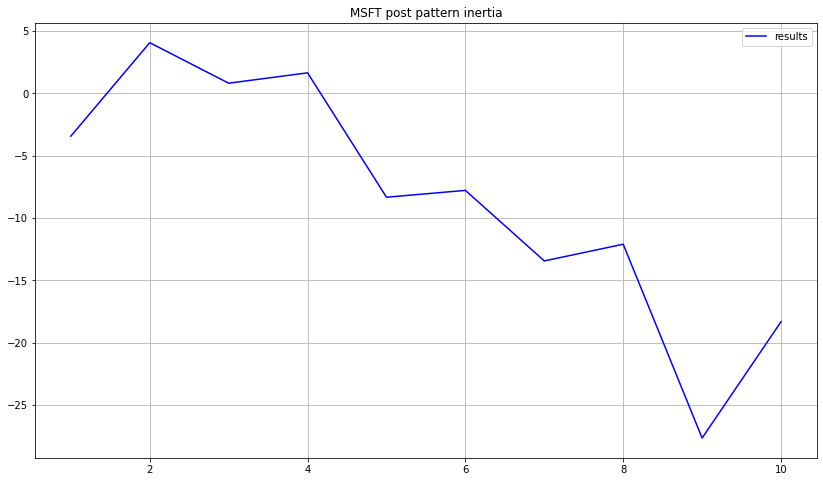


Pattern analysis on: NKE

Occurrences: 9 

DatetimeIndex(['2007-05-23', '2007-10-11', '2012-05-04', '2014-05-14',
               '2016-08-25', '2017-02-16', '2017-07-05', '2018-03-28',
               '2019-07-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.26 average of -0.25 with 3 winning trades and 6 loosing trades
After: 2 days: -1.8 average of -0.2 with 3 winning trades and 6 loosing trades
After: 3 days: -5.98 average of -0.66 with 3 winning trades and 6 loosing trades
After: 4 days: -4.36 average of -0.48 with 3 winning trades and 6 loosing trades
After: 5 days: -6.77 average of -0.75 with 3 winning trades and 6 loosing trades
After: 6 days: -3.84 average of -0.43 with 3 winning trades and 6 loosing trades
After: 7 days: -2.02 average of -0.22 with 3 winning trades and 6 loosing trades
After: 8 days: -2.63 average of -0.29 with 3 winning trades and 6 loosing trades
After: 9 days: -0.04 average of -0.0 with 3 winning trades and 6 loosing t

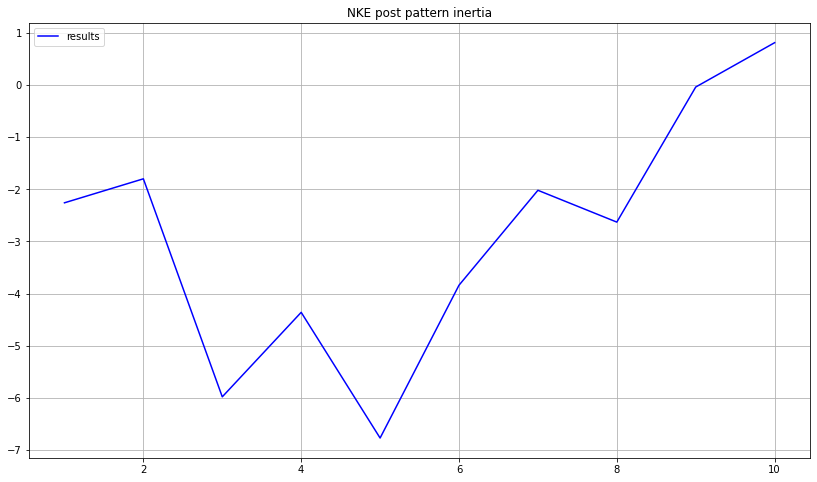


Basket analysis:
Positive inertia after 1 bars: ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'KO', 'HD', 'MCD']
Positive inertia after 2 bars: ['MMM', 'AXP', 'BA', 'CAT', 'KO', 'XOM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 3 bars: ['MMM', 'AXP', 'BA', 'CAT', 'KO', 'XOM', 'INTC', 'JPM', 'MSFT']
Positive inertia after 4 bars: ['MMM', 'AXP', 'BA', 'CAT', 'XOM', 'INTC', 'JPM', 'MCD', 'MSFT']
Positive inertia after 5 bars: ['MMM', 'AXP', 'BA', 'CAT', 'KO', 'XOM', 'INTC', 'JNJ', 'JPM', 'MCD']
Positive inertia after 6 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CVX', 'XOM', 'JNJ', 'JPM', 'MCD']
Positive inertia after 7 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CVX', 'XOM', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD']
Positive inertia after 8 bars: ['MMM', 'AXP', 'BA', 'CVX', 'XOM', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD']
Positive inertia after 9 bars: ['MMM', 'BA', 'CAT', 'CVX', 'KO', 'XOM', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD']
Positive inertia after 10 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CVX', 'KO', 'XOM', '

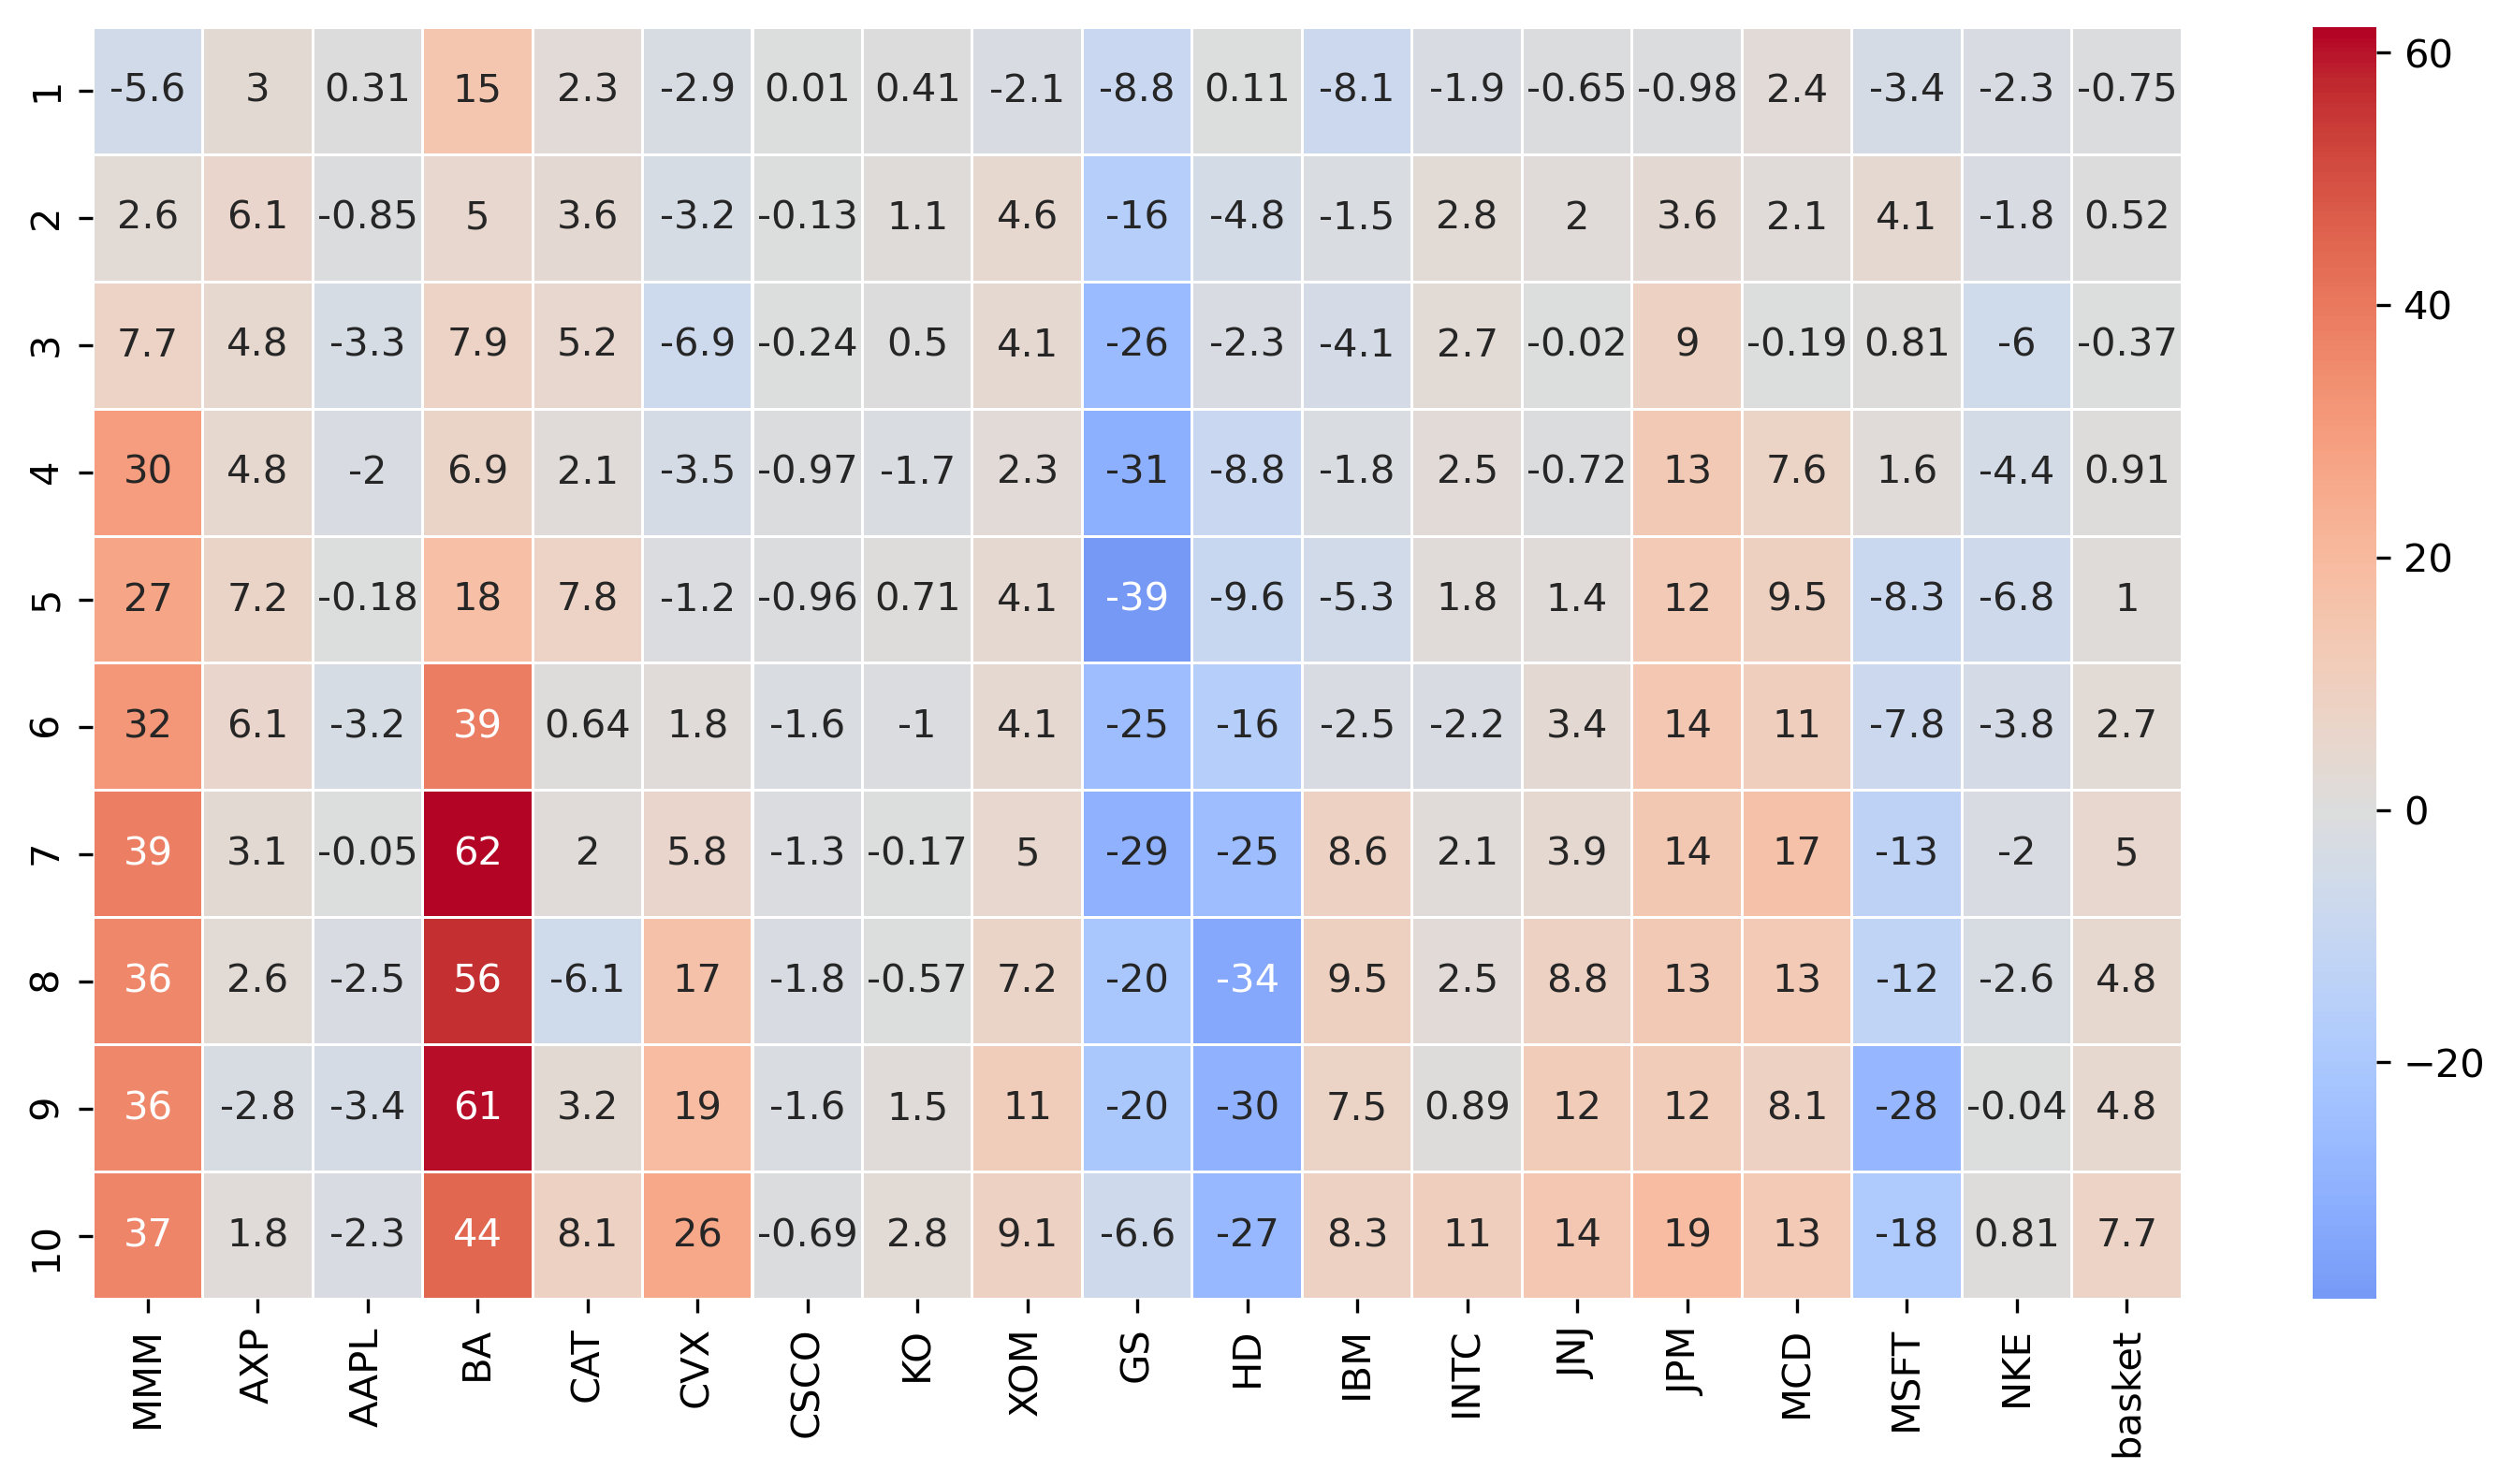

In [12]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = ((dataset.high.shift(1) > dataset.BBU.shift(1))) & \
              (dataset.close < dataset.open) & (dataset.close.shift(2) > dataset.open.shift(2)) & \
              (dataset.close_pos < 30) & (dataset.open_pos > 70) &\
              (dataset.close_pos.shift(2) > 70) & (dataset.open_pos.shift(2) < 30) & \
              (dataset.range_perc > 1) & (dataset.range_perc.shift(2) > 1) & (dataset.body_perc.shift(1) < 1)
    
    results = pattern_stats(dataset, pattern, "short", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [13]:
basket_results.iplot(title = "Pattern inertia")